### TITLE HERE

In [3827]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import matplotlib.ticker as mticker
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

<style>
  table {
      width: 100%;
      border-collapse: collapse;
      font-family: Arial, sans-serif;
      font-size: 1.1em;
  }
  th, td {
      text-align: left;
      padding: 12px;
  }
  th {
      background-color: #15616d;
      color: white;
  }
  tr:nth-child(odd) {
      background-color: #ffecd1;
  }
  tr:nth-child(even) {
      background-color: #f2f2f2;
  }
  tr:hover {
      background-color: #ff7d00;
      color: white;
  }
</style>

<table>
    <tr><th>Variable Name</th><th>Possible Values and Explanation</th></tr>
    <tr><td><strong>reference_date</strong></td><td>Dates representing the reference period for the data.</td></tr>
    <tr><td><strong>index</strong></td><td>A unique identifier for each record.</td></tr>
    <tr><td><strong>gender</strong></td><td>M: Male, F: Female</td></tr>
    <tr><td><strong>car_ownership</strong></td><td>Yes: Owns a car, No: Does not own a car</td></tr>
    <tr><td><strong>house_ownership</strong></td><td>Yes: Owns a house, No: Does not own a house</td></tr>
    <tr><td><strong>children_count</strong></td><td>Number of children the individual has.</td></tr>
    <tr><td><strong>income_type</strong></td><td>
        Entrepreneur: Owns a business, Salaried: Earns a fixed salary, 
        Public Servant: Works for the government, Pensioner: Receives a pension, 
        Scholarship Holder: Receives a scholarship
    </td></tr>
    <tr><td><strong>education</strong></td><td>
        High School: Completed secondary education, 
        Incomplete Higher: Some higher education but not completed, 
        Complete Higher: Completed higher education, 
        Primary: Completed primary education, 
        Postgraduate: Completed education beyond a bachelor's degree
    </td></tr>
    <tr><td><strong>marital_status</strong></td><td>
        Single: Not married, Married: Legally married, 
        Union: In a domestic partnership, Separated: Legally separated, 
        Widowed: Lost spouse to death
    </td></tr>
    <tr><td><strong>residence_type</strong></td><td>
        House: Lives in a private house, With Parents: Lives with parents, 
        Rented: Rents a residence, Community: Lives in community housing, 
        Governmental: Lives in government-provided housing, 
        Studio: Lives in a studio apartment
    </td></tr>
    <tr><td><strong>age</strong></td><td>Age of the individual in years.</td></tr>
    <tr><td><strong>employment_time</strong></td><td>Number of years the individual has been employed.</td></tr>
    <tr><td><strong>residents_count</strong></td><td>Number of people living in the same residence.</td></tr>
    <tr><td><strong>income</strong></td><td>Monthly income of the individual.</td></tr>
    <tr><td><strong>default</strong></td><td>0: No default, 1: Defaulted on a loan or payment</td></tr>
</table>


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">📥 Importing Data</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this first step, we are importing the Feather file containing our dataset from an S3 bucket. Importing data in this manner offers several advantages:
    </p>
</div>

---

<p style="fo3t-size: 1.4em;">
<strong>1 - S3 is super fast</strong> and it saves us from having a heavier GitHub repository, abstracting some complexity.
</p>

<p style3"font-size: 1.4em;">
<strong>2 - Feather files</strong> are more efficient than CSVs in Python because they support faster read/write operations and are optimized for memory usage, making them ideal for large datasets.
</p>


In [3557]:
# S3 bucket and object key
bucket_name = 'dataset-content-pedrohang'
object_key = 'credit-scoring/credit_scoring.ftr'

# Constructing the S3 URI
s3_uri = f's3://{bucket_name}/{object_key}'

# Reading the feather file from S3
df = pd.read_feather(s3_uri, storage_options={'anon': True})

In [3558]:
df.head(3)

,reference_date,index,gender,car_ownership,house_ownership,children_count,income_type,education,marital_status,residence_type,age,employment_time,residents_count,income,default
0,2015-01-01,5733,F,No,No,0,Entrepreneur,High School,Single,House,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,Yes,Yes,0,Salaried,High School,Married,House,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,No,No,2,Salaried,High School,Married,House,31,0.243836,4.0,1582.29,False


In [3559]:
print("The Dataset has " + str(df.shape[0]) + " Entries")

The Dataset has 750000 Entries


### We are going to delete the 'index' column since it is not useful for either analysis or modelling

In [3561]:
df.drop(columns=['index'], inplace=True)

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">⚙️ Important Functions</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this section, we define key functions to streamline the Exploratory Data Analysis (EDA) process for the dataset. These functions are designed to simplify both univariate and bivariate analysis, providing powerful tools to better understand your data.
    </p>
    <p style="font-size: 1.2em; text-align: center;">
        You can explore these functions and many more for EDA and machine learning modeling in my public GitHub repository: 
        <a href="https://github.com/PedroHang/Templates-and-Functions" style="color: #ffecd1; text-decoration: none; font-weight: bold;">GitHub Repository</a>.
    </p>
</div>

---

## 🌟 Function: `univ_plot`
This function facilitates univariate analysis on a given DataFrame, allowing you to visualize either categorical or continuous variables. It's a versatile tool for initial data exploration and provides quick insights into individual feature distributions.

---

## 🌟 Function: `univ_plotly`
The `univ_plotly` function is designed for univariate analysis using Plotly, offering interactive visualizations. It's particularly effective for exploring categorical variables, providing a dynamic and engaging way to analyze your data. Note that when working with continuous variables, this function may perform more slowly, in which case the `univ_plot` function is recommended for better efficiency.

---

## 🌟 Function: `biv_plot`
The `biv_plot` function is your go-to for bivariate analysis. Whether you are examining relationships between categorical variables, continuous variables, or a mix of both, this function helps you visualize the interactions and correlations within your data.

---

These functions are essential tools in any data scientist's arsenal, designed to make the EDA process more efficient and insightful. Don't forget to check out the full collection of templates and functions in the linked GitHub repository for more powerful data analysis tools!


### Functions:
(You can collapse this if you want to hide the cells that are defining the functions)

In [3564]:
def univ_plot(df, threshold=15, categorical=True, log=False):
    import random
    import numpy as np
    
    # Determine categorical and continuous columns
    categorical_columns = [col for col in df.columns if df[col].nunique() <= threshold]
    continuous_columns = [col for col in df.columns if df[col].nunique() > threshold]
    
    if categorical:
        # Plot categorical variables
        num_plots = len(categorical_columns)
        if num_plots == 0:
            print("No categorical variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, categorical_columns):
            plot = sns.countplot(x=col, data=df, hue=col, legend=False, ax=ax)
            ax.set_title(f'Count of {col}', fontsize=20)
            ax.set_xlabel(col, fontsize=18)
            ax.set_ylabel('Count', fontsize=18)
            ax.tick_params(axis='x', rotation=45, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
            
            # Annotate each bar with the count if the variable has 10 or fewer categories
            if df[col].nunique() <= 10:
                for p in plot.patches:
                    plot.annotate(format(p.get_height(), '.0f'), 
                                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                                  ha = 'center', va = 'center', 
                                  xytext = (0, 9), 
                                  textcoords = 'offset points',
                                  fontsize=14)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    else:
        # Define a list of colors
        colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', 
            '#d62728', '#9467bd', '#8c564b', 
            '#e377c2', '#7f7f7f', '#bcbd22', 
            '#17becf'
        ]
        
        # Plot continuous variables
        num_plots = len(continuous_columns)
        if num_plots == 0:
            print("No continuous variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, continuous_columns):
            data = np.log(df[col]) if log else df[col]
            color = random.choice(colors)
            sns.violinplot(y=data, ax=ax, color=color)
            ax.set_title(f'Violin Plot of {col}', fontsize=20)
            ax.set_ylabel(col, fontsize=18)
            ax.tick_params(axis='y', labelsize=16)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()

In [3565]:
def univ_plotly(df, threshold=15, categorical=True, log=False):

    ### Importing the packages
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import numpy as np
    
    # Determine categorical and continuous columns
    categorical_columns = [col for col in df.columns if df[col].nunique() <= threshold]
    continuous_columns = [col for col in df.columns if df[col].nunique() > threshold]
    
    if categorical:
        # Plot categorical variables
        num_plots = len(categorical_columns)
        if num_plots == 0:
            print("No categorical variables to plot.")
            return
        
        # Create subplots with 2 columns
        fig = make_subplots(rows=(num_plots // 2) + (num_plots % 2), cols=2, subplot_titles=categorical_columns)
        
        for i, col in enumerate(categorical_columns):
            row = (i // 2) + 1
            col_num = (i % 2) + 1
            fig.add_trace(
                go.Bar(x=df[col].value_counts().index, y=df[col].value_counts().values, name=col),
                row=row, col=col_num
            )
            fig.update_xaxes(title_text=col, row=row, col=col_num)
            fig.update_yaxes(title_text='Count', row=row, col=col_num)

        fig.update_layout(height=400 * ((num_plots // 2) + (num_plots % 2)), width=1200, title_text="Categorical Variable Distribution")
        fig.show()
    else:
        # Plot continuous variables
        num_plots = len(continuous_columns)
        if num_plots == 0:
            print("No continuous variables to plot.")
            return
        
        # Create subplots with 2 columns
        fig = make_subplots(rows=(num_plots // 2) + (num_plots % 2), cols=2, subplot_titles=continuous_columns)
        
        for i, col in enumerate(continuous_columns):
            row = (i // 2) + 1
            col_num = (i % 2) + 1
            data = np.log(df[col]) if log else df[col]
            fig.add_trace(
                go.Box(y=data, name=col),
                row=row, col=col_num
            )
            fig.update_yaxes(title_text=col, row=row, col=col_num)
        
        fig.update_layout(height=400 * ((num_plots // 2) + (num_plots % 2)), width=1200, title_text="Continuous Variable Distribution")
        fig.show()

In [3566]:
def biv_plot(df, x, y, threshold=15, sample_size=500):
    from statsmodels.graphics.mosaicplot import mosaic
    # Determine if the variables are categorical or continuous
    x_is_categorical = df[x].nunique() <= threshold
    y_is_categorical = df[y].nunique() <= threshold

    plt.figure(figsize=(10, 6))

    if not x_is_categorical and not y_is_categorical:
        # Scenario 1: Continuous x Continuous
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sample for scatter plot if dataset is large
        if len(df) > sample_size:
            df_sampled = df.sample(sample_size)
        else:
            df_sampled = df
        
        sns.regplot(x=x, y=y, data=df_sampled, ax=ax, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'}) # Scatter Plot with Regression Line
        ax.set_title(f'Scatter Plot with Regression Line: {x} vs {y}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        
        plt.tight_layout()
        plt.show()

    elif x_is_categorical and not y_is_categorical:
        # Scenario 2: Continuous x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=x, y=y, data=df, ax=axs[0, 0], hue=x) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=x, y=y, data=df, ax=axs[0, 1], hue=x) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=x, y=y, data=df, jitter=True, ax=axs[1, 0], hue=x) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=x, y=y, data=df, ax=axs[1, 1], hue=x) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    elif not x_is_categorical and y_is_categorical:
        # Scenario 2: Categorical x Continuous (swapped)
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=y, y=x, data=df, ax=axs[0, 0], hue=y) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=y, y=x, data=df, ax=axs[0, 1], hue=y) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=y, y=x, data=df, jitter=True, ax=axs[1, 0], hue=y) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=y, y=x, data=df, ax=axs[1, 1], hue=y) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    else:
        # Scenario 3: Categorical x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # Stacked Bar Chart
        crosstab = pd.crosstab(df[x], df[y])
        crosstab_perc = crosstab.div(crosstab.sum(1), axis=0)
        crosstab_perc.plot(kind='bar', stacked=True, ax=axs[0, 0])
        axs[0, 0].set_title('Stacked Bar Chart')
        axs[0, 0].tick_params(axis='x', rotation=45)

        # Add percentage labels on top of the bars for Stacked Bar Chart
        for container in axs[0, 0].containers:
            axs[0, 0].bar_label(container, labels=[f'{v * 100:.1f}%' for v in container.datavalues], label_type='center')

        # Grouped Bar Chart
        crosstab.plot(kind='bar', ax=axs[0, 1])
        axs[0, 1].set_title('Grouped Bar Chart')
        axs[0, 1].tick_params(axis='x', rotation=45)

        # Add values on top of the bars for Grouped Bar Chart
        for container in axs[0, 1].containers:
            axs[0, 1].bar_label(container)

        # Mosaic Plot
        mosaic(df, [x, y], ax=axs[1, 0])
        axs[1, 0].set_title('Mosaic Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        # Count Plot
        sns.countplot(x=x, hue=y, data=df, ax=axs[1, 1])
        axs[1, 1].set_title('Count Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">✂️ Data Split and Initial Clean</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this step, we are going to separate a portion of the data (the last 3 months) for <b>Out-of-time</b> validations.
    </p>
</div
-


<div style="text-align: center;">
  <img src="https://github.com/PedroHang/Credit-Scoring-Project/blob/main/Images/oot_example.png?raw=true" alt="OOT" width="600"/>
</div>


<b>Out-of-time validation</b> is a technique used in predictive modeling, particularly in credit scoring and other financial applications, to evaluate the performance of a model on data that is truly unseen and represents future periods.

Before splitting the data, we are going to:
- Set our 'answer' variable 'default' as int.
- Plot a heatmap in order to identify the pattern of missing values across our features
- Define a function to better address the filling technique we are using

In [3571]:
df['default'].value_counts()

default
False    691357
True      58643
Name: count, dtype: int64

In [3572]:
df['default'] = df.default.astype('int64')

In [3573]:
df['not_default'] = 1 - df['default']

In [3574]:
df.isna().sum()

C:\Users\Hanga\anaconda3\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


reference_date          0
gender                  0
car_ownership           0
house_ownership         0
children_count          0
income_type             0
education               0
marital_status          0
residence_type          0
age                     0
employment_time    125957
residents_count         0
income                  0
default                 0
not_default             0
dtype: int64

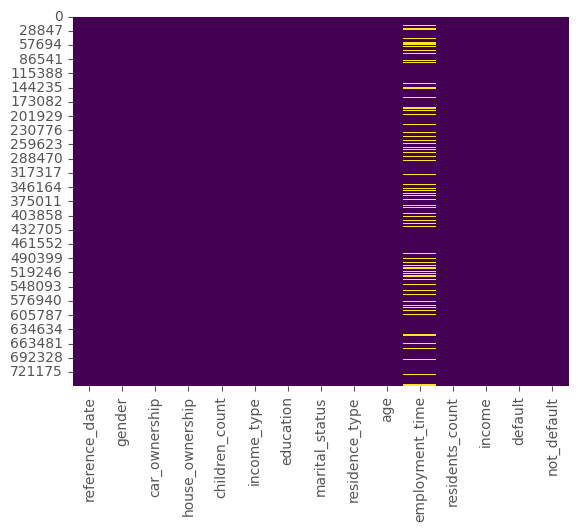

In [3575]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

The only variable that has missing values is "employment-time". The missing values are well distributed throughout the data.

Here, we are going to drop the columns where there are missing values

In [3578]:
def drop_missing_values(df):
    # Drop rows with any missing values
    df.dropna(inplace=True)
    
    return df

In [3579]:
df_filled = drop_missing_values(df)

In [3580]:
df_filled.isna().sum()

reference_date     0
gender             0
car_ownership      0
house_ownership    0
children_count     0
income_type        0
education          0
marital_status     0
residence_type     0
age                0
employment_time    0
residents_count    0
income             0
default            0
not_default        0
dtype: int64

### Performing the split

In [3582]:
df_train = df_filled[df_filled['reference_date'] <= '2015-12-31']
df_oot = df_filled[df_filled['reference_date'] >= '2016-01-01']

In [3583]:
print(df_train.shape)

(499125, 15)


In [3584]:
print(df_oot.shape)

(124918, 15)


- The train dataset has 600,000 entries
- The Out-of-Time dataset has 150,000 entries

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🔍 Univariate Analysis</h1>
    <p style="font-size: 1.2em; text-align: center;">
        The univariate analysis performed in this step aims to highlight imbalances and important features present in our dataset. Here, we use the functions defined in the previous step to do the heavy lifting for us.
    </p>
</div>

---
>

---


### Let's start by performing an univariate analysis with the categorical data from our dataset. Here, we are using the 'univ_plot' function that we have set earlier.

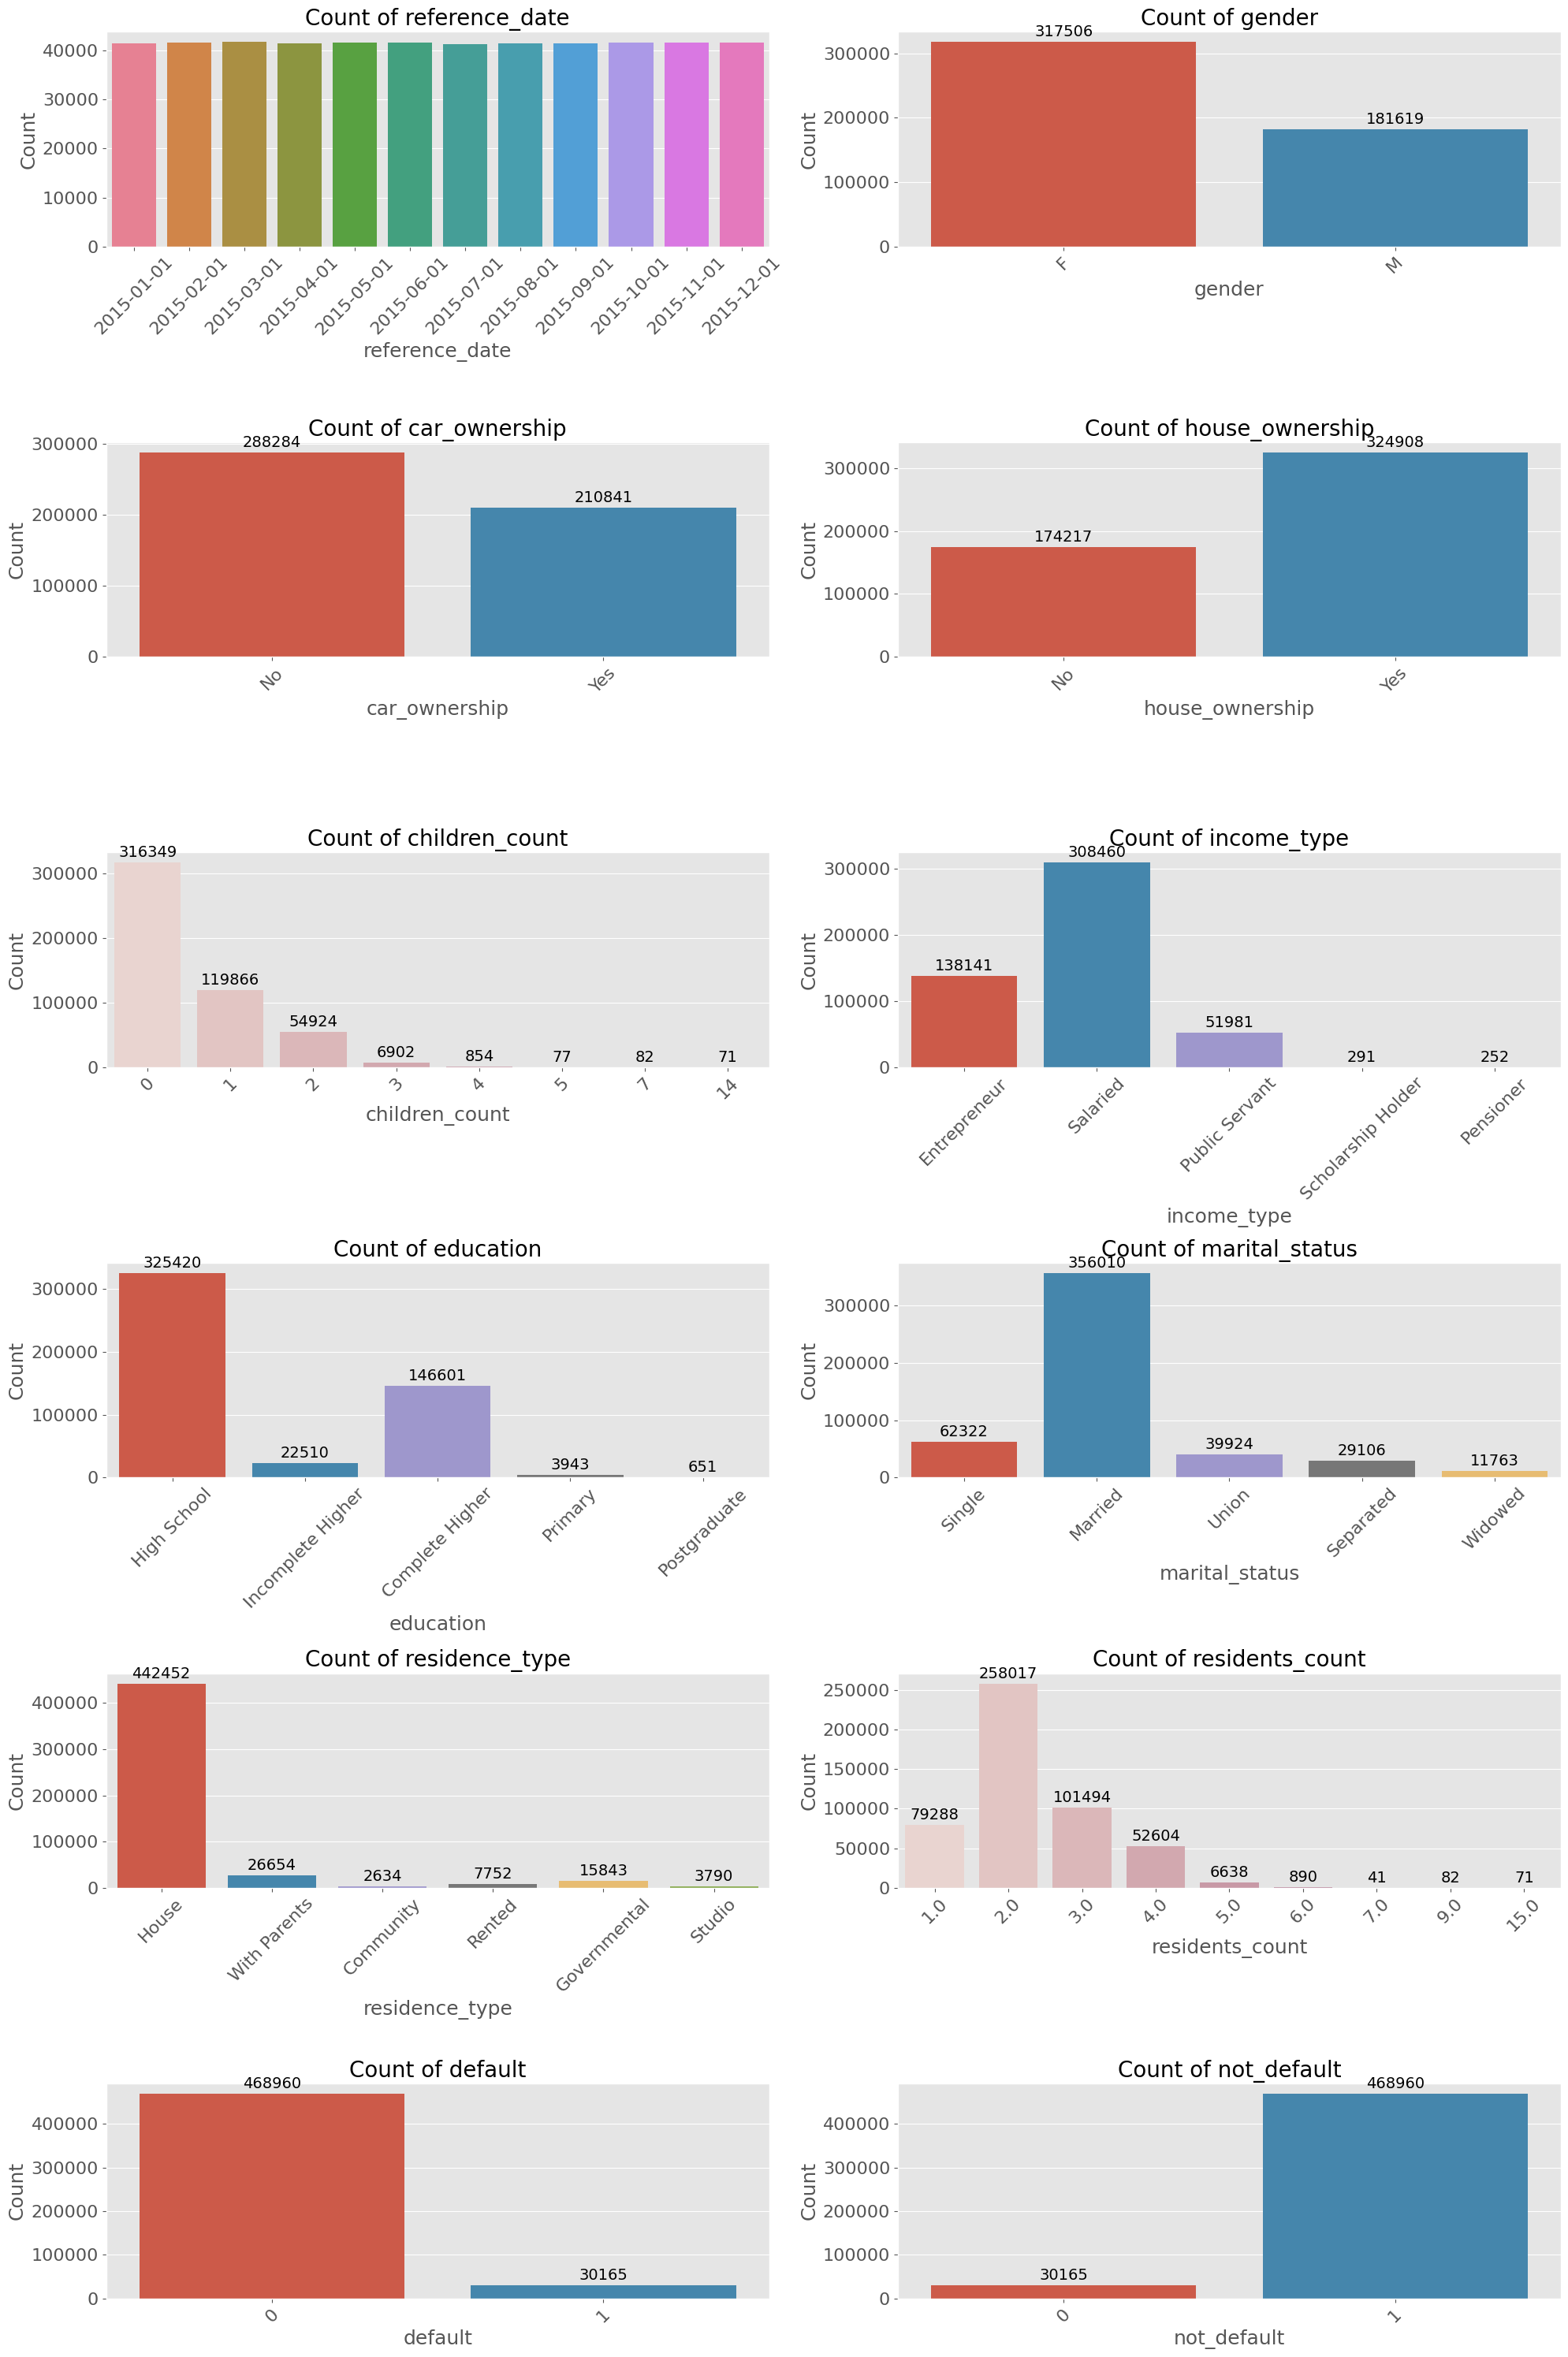

CPU times: total: 17.2 s
Wall time: 18.2 s


In [3588]:
%%time
univ_plot(df_train)

### **Reference Date**- **Balance**: Data collection is balanced across all months (2015/01/01 - 2015/12/01).

### **Gender**
- **Imbalance**: Significant, with a higher proportion of Female records.
- **Potential Impact**: Could bias the model towards predicting outcomes more accurately for the majority gender.

### **Car Ownership**
- **Imbalance**: Majority of records indicate no car ownership.
- **Potential Impact**: May skew predictions towards non-car owners.

### **House Ownership**
- **Imbalance**: Majority of records show house ownership.
- **Potential Impact**: Model may favor predictions for homeowners.

### **Children Count**
- **Imbalance**: Most records have zero children.
- **Potential Impact**: Could lead to a model that underestimates outcomes for larger families.

### **Income Type**
- **Imbalance**: Dominance of salaried individuals.
- **Potential Impact**: Model might be biased towards outcomes typical for salaried individuals.

### **Education**
- **Imbalance**: High School education is the most common.
- **Potential Impact**: Model could overrepresent outcomes typical for this education level.

### **Marital Status**
- **Imbalance**: Most records are for married individuals.
- **Potential Impact**: May lead to biased predictions favoring married individuals.

### **Residence Type**
- **Imbalance**: Majority live in houses.
- **Potential Impact**: Model may underrepresent outcomes for those in other residence types.

### **Residents Count**
- **Imbalance**: Most households have 1 or 2 residents.
- **Potential Impact**: Larger households may be underrepresented in predictions.

### **Default Status**
- **Imbalance**: Most records indicate no default.
- **Potential Impact**: The model may struggle to predict defaults accurately.


### Let's now perform an univariate analysis with the continuous data from our dataset. Here, we are using the 'univ_plot' function that we have set earlier.

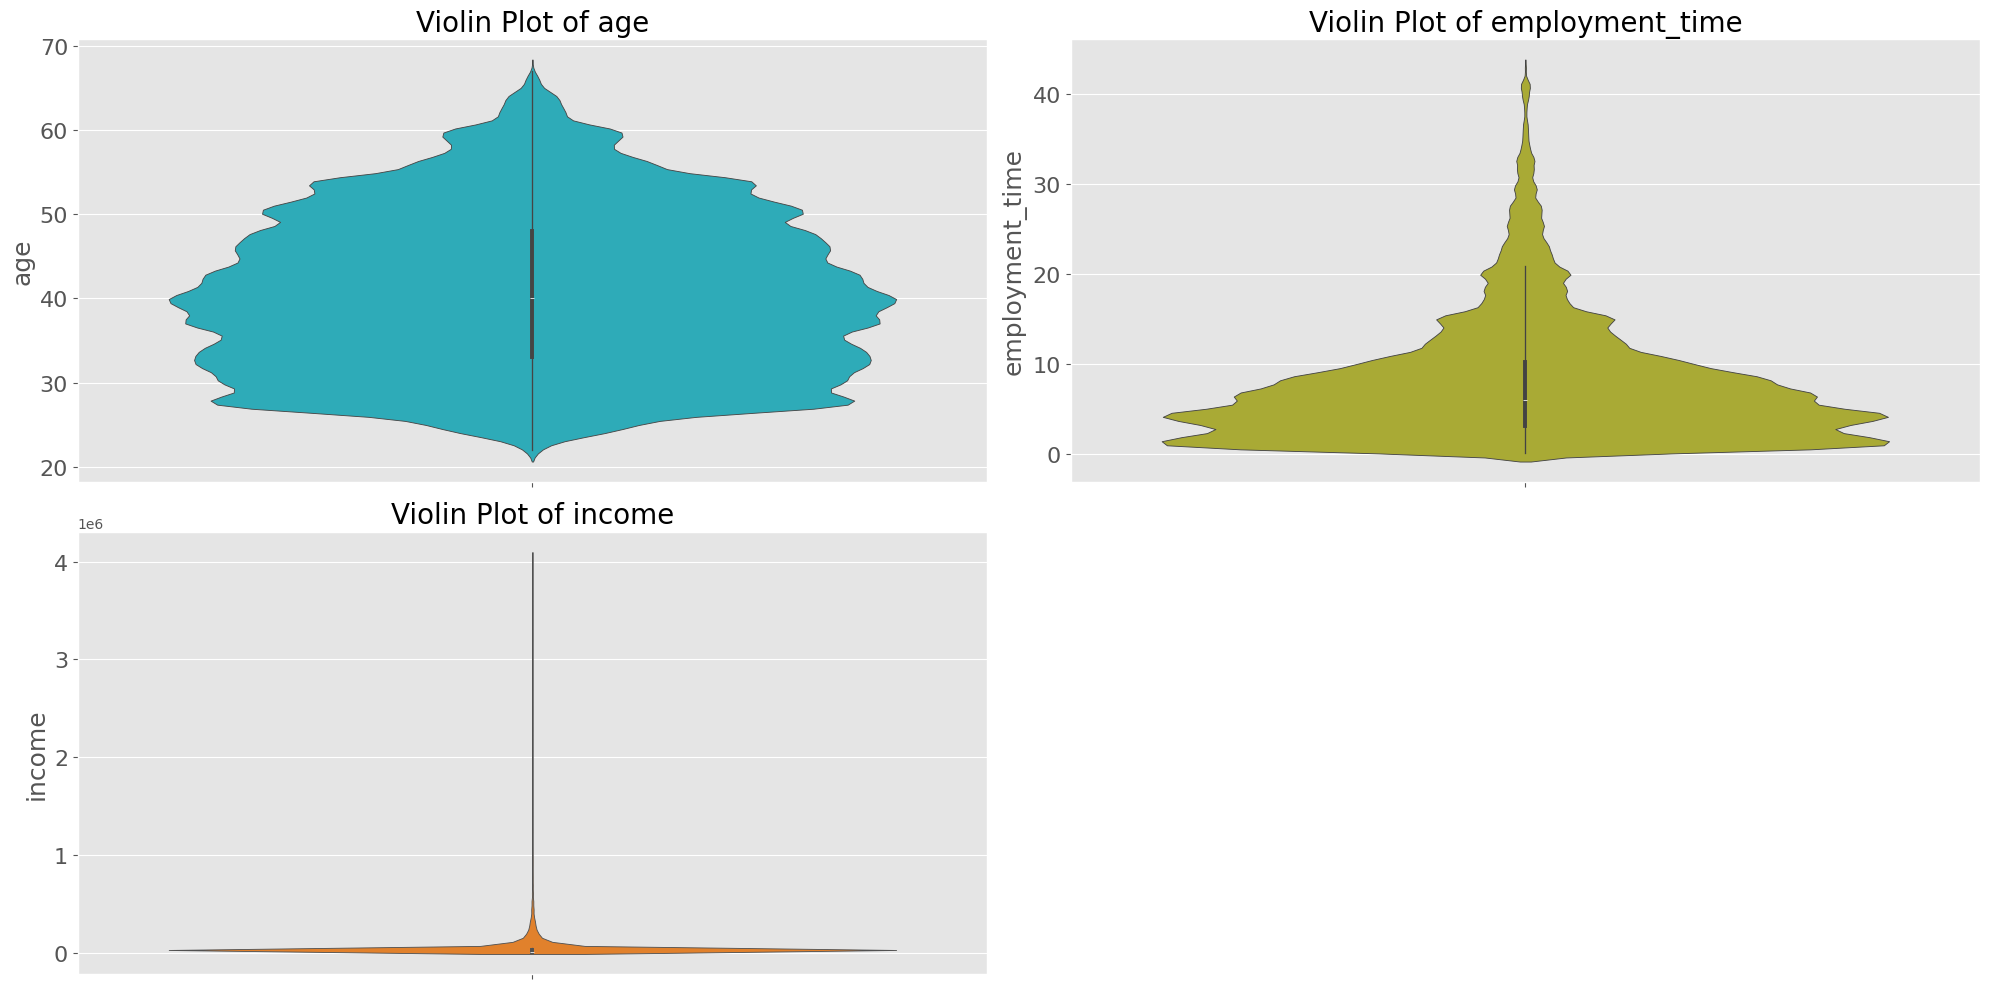

In [3591]:
univ_plot(df_train, categorical=False)

### **Age**

- **Distribution**: The age distribution appears to be fairly symmetrical, with most individuals clustered between **30 to 50 years**.
- **Potential Impact**: The model may perform well across different age groups, with no evident skew towards a particular age range.

### **Employment Time**

- **Distribution**: The distribution is skewed towards lower employment times, with a peak near the beginning of employment and a long tail extending to longer employment durations.
- **Potential Impact**: The model may emphasize early employment periods, potentially underestimating the influence of long-term employment.

### **Income**

- **Distribution**: The income distribution is highly skewed, with a large number of individuals earning low to moderate incomes and a very few earning exceptionally high incomes.
- **Potential Impact**: This skewness may cause the model to underperform in predicting outcomes for high-income individuals, as they are underrepresented.


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🔍 Bivariate Analysis</h1>
    <p style="font-size: 1.2em; text-align: center;">
        The bivariate analysis performed on this step aims to highlight some of the relationships between key variables for our model.
    </p>
</div>

---
>


### For reference: Let's calculate the "baseline" % of default in our train set.

In [3595]:
total = 563357 + 36643
default_percentage = (36643 / total) * 100
print(default_percentage)

6.107166666666667


### *Around 6.1%*

### **Default Rates by Gender in the Training Set**

<Figure size 1000x600 with 0 Axes>

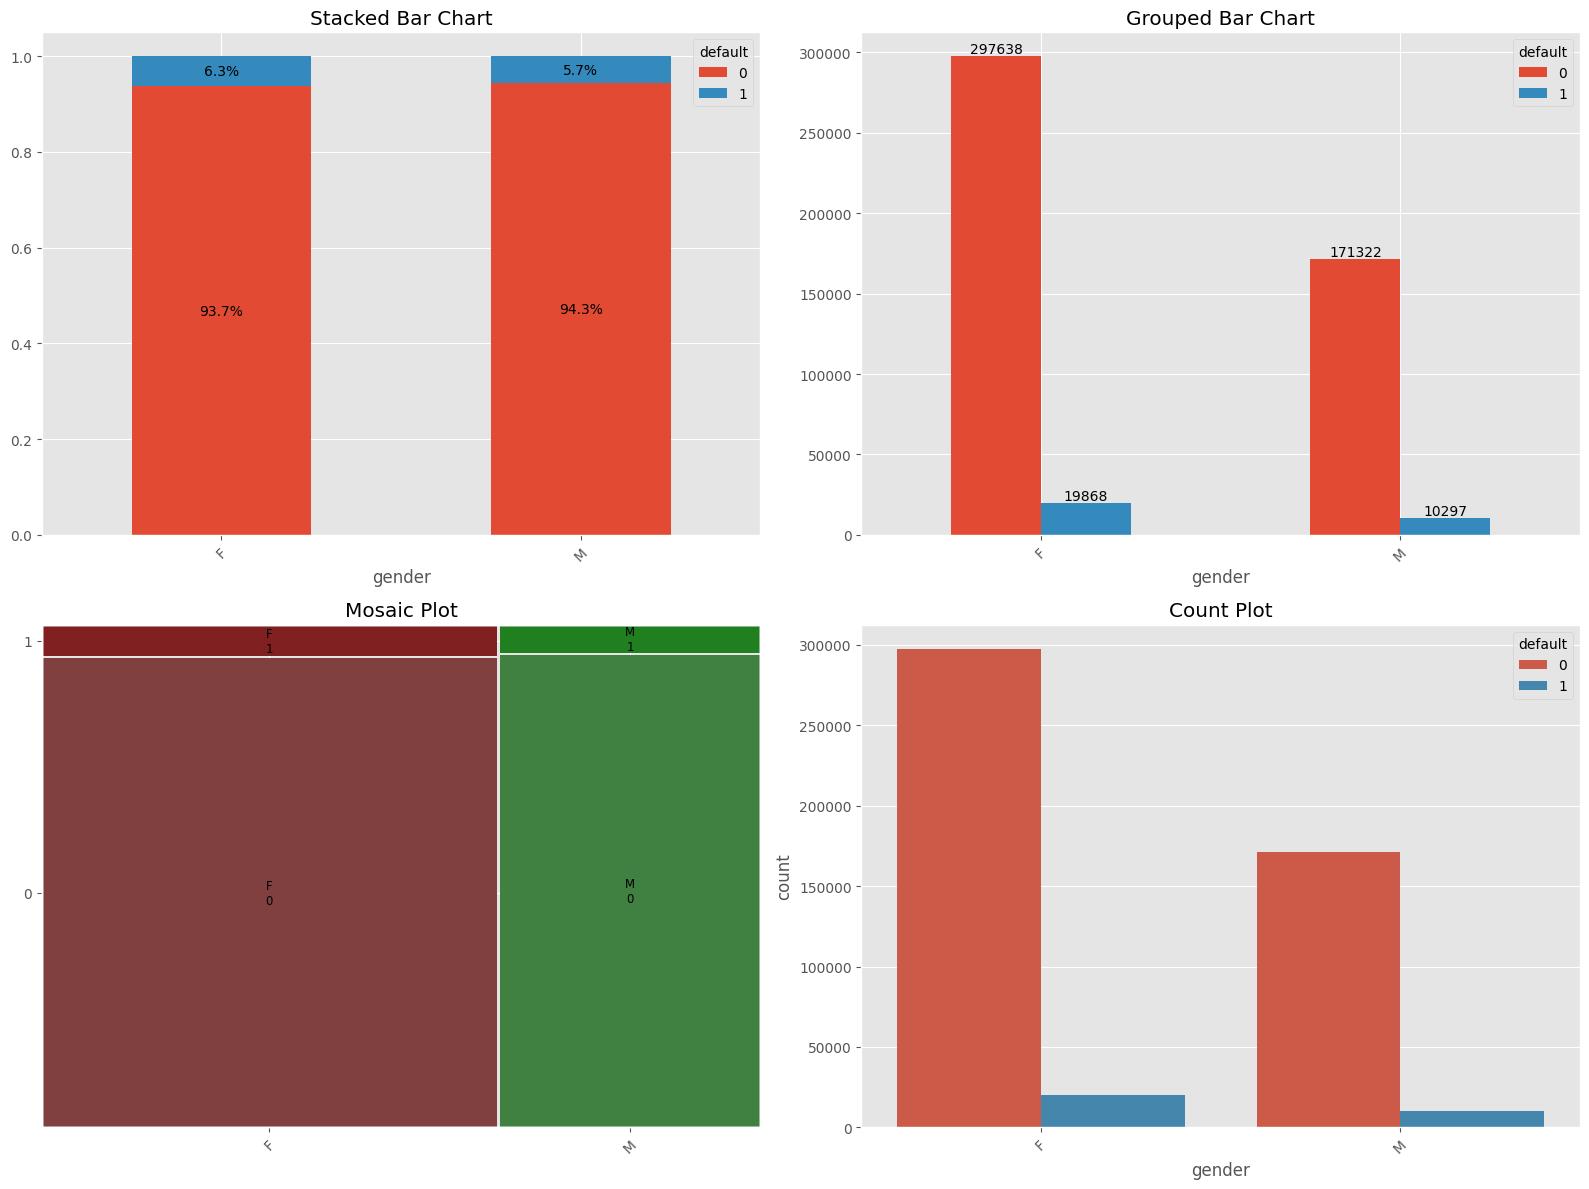

In [3598]:
biv_plot(df_train, x='gender', y='default', threshold=15)

- **Female Default Rate**: **6.3%**
- **Male Default Rate**: **5.7%**

This observation indicates a slightly higher tendency for females to default compared to males in our training dataset.


---

### **Default Rates by Car Ownership**

<Figure size 1000x600 with 0 Axes>

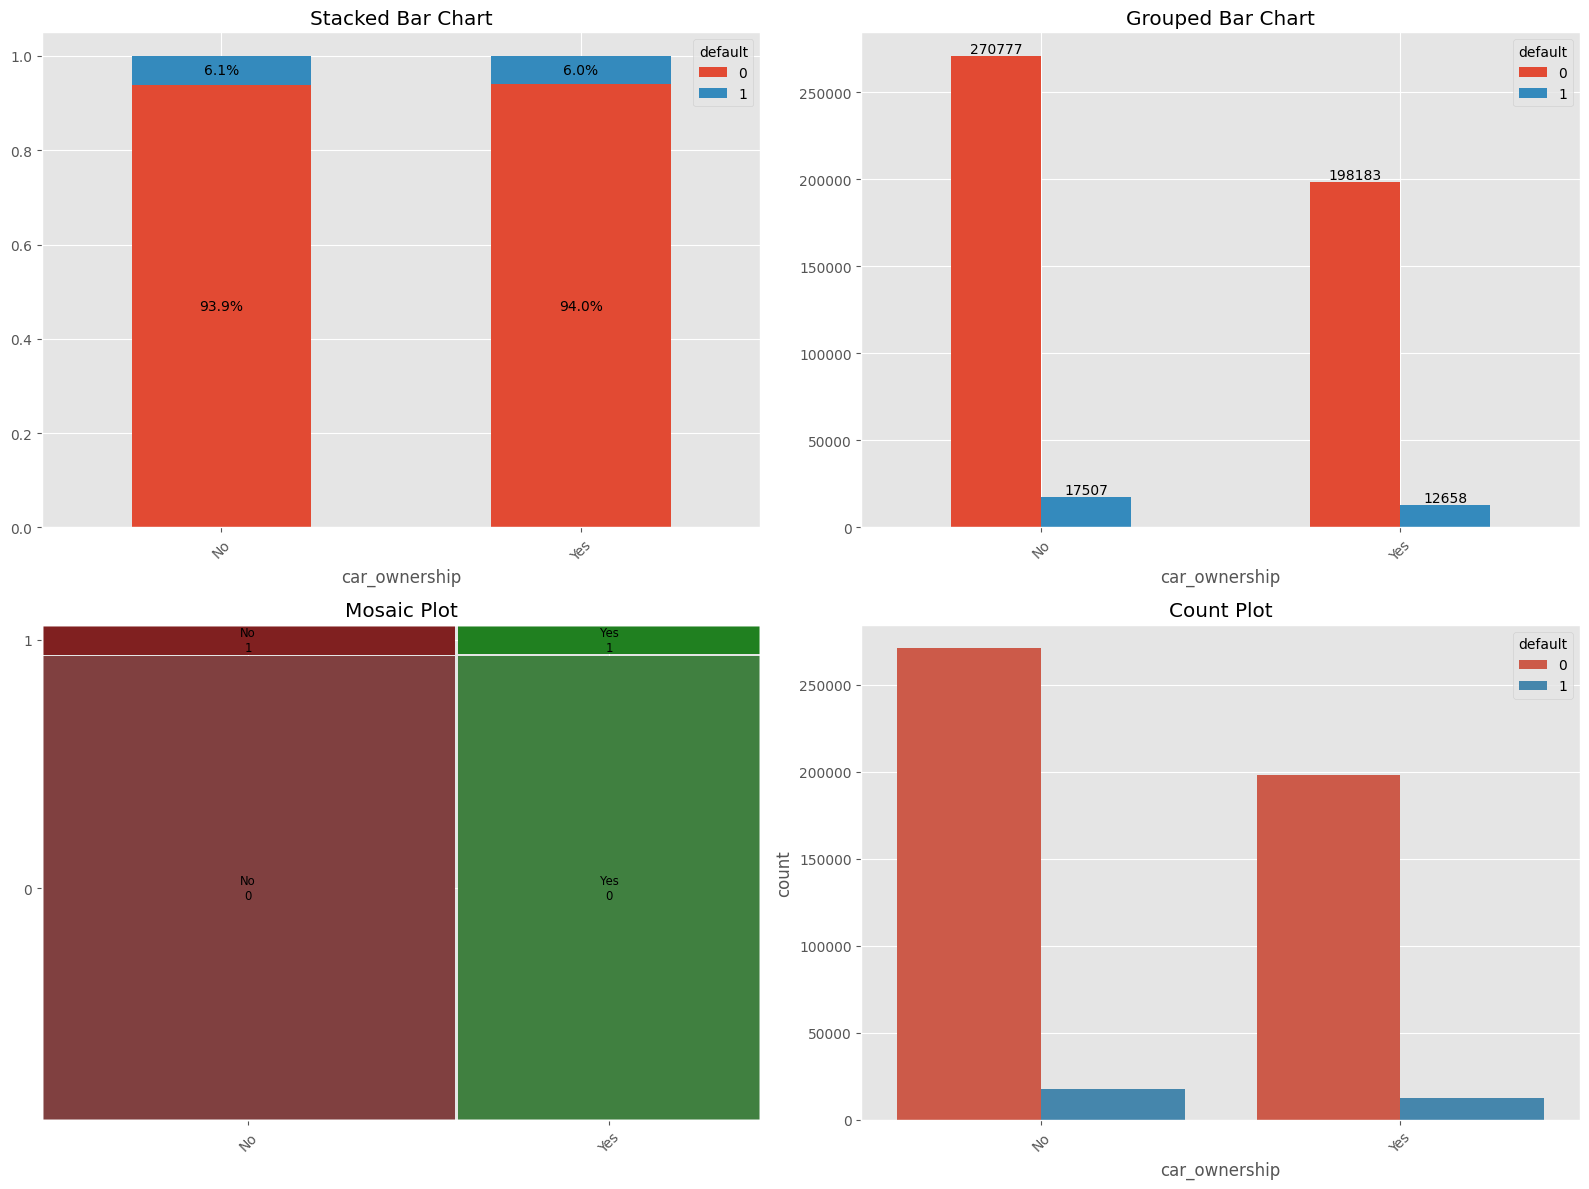

In [3602]:
biv_plot(df_train, x='car_ownership', y='default', threshold=15)

This comparison shows a very slight difference in default rates between individuals who own a car and those who do not. The distribution of defaults is almost identical, regardless of car ownership.

---

### **Default Rates by Number of Children**

<Figure size 1000x600 with 0 Axes>

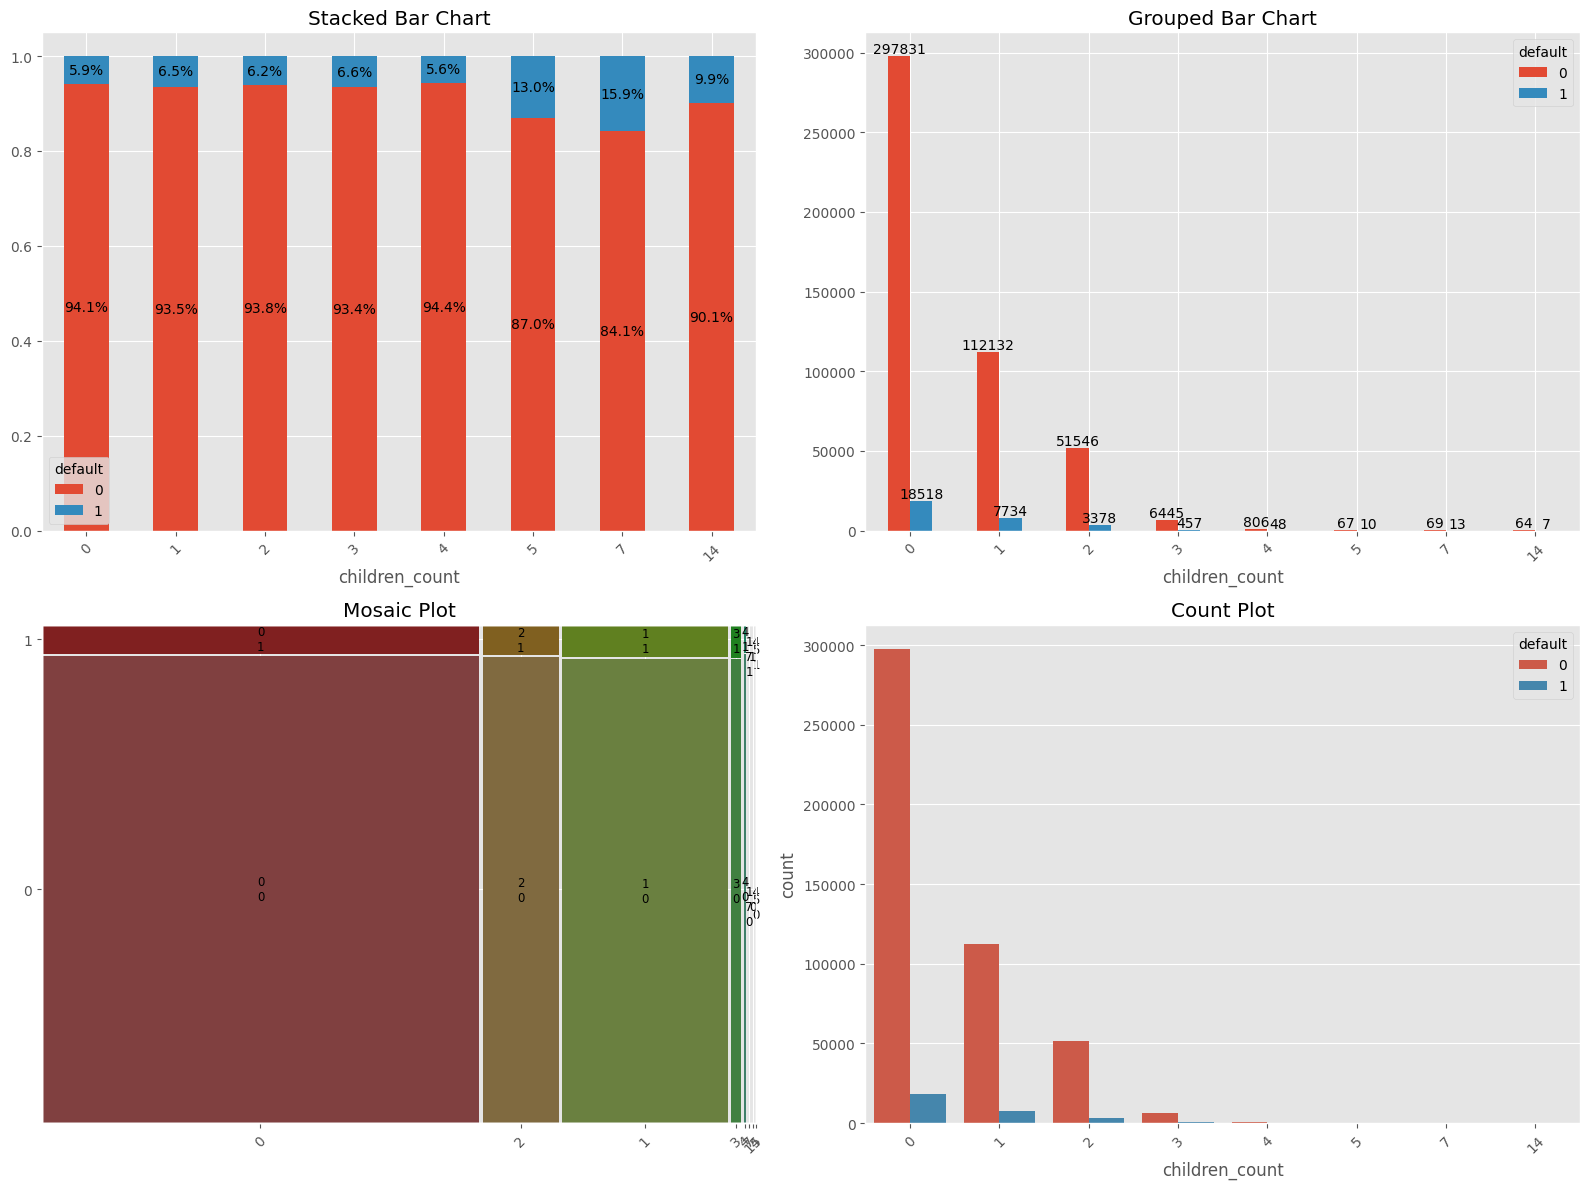

In [3606]:
biv_plot(df_train, x='children_count', y='default', threshold=15)

This analysis shows that the default rate tends to increase with the number of children, particularly for those with 5 or more children, suggesting a potential higher financial strain in larger households. It is important to consider that due to the imbalance of the data, the default rates for families that have more than 3 children may not be very reliable.

Values that are too small, may be merged together in order to reduce potential biases towards discrepant values that may arise from a small sample.

---

### **Default Rates by Income Type**

<Figure size 1000x600 with 0 Axes>

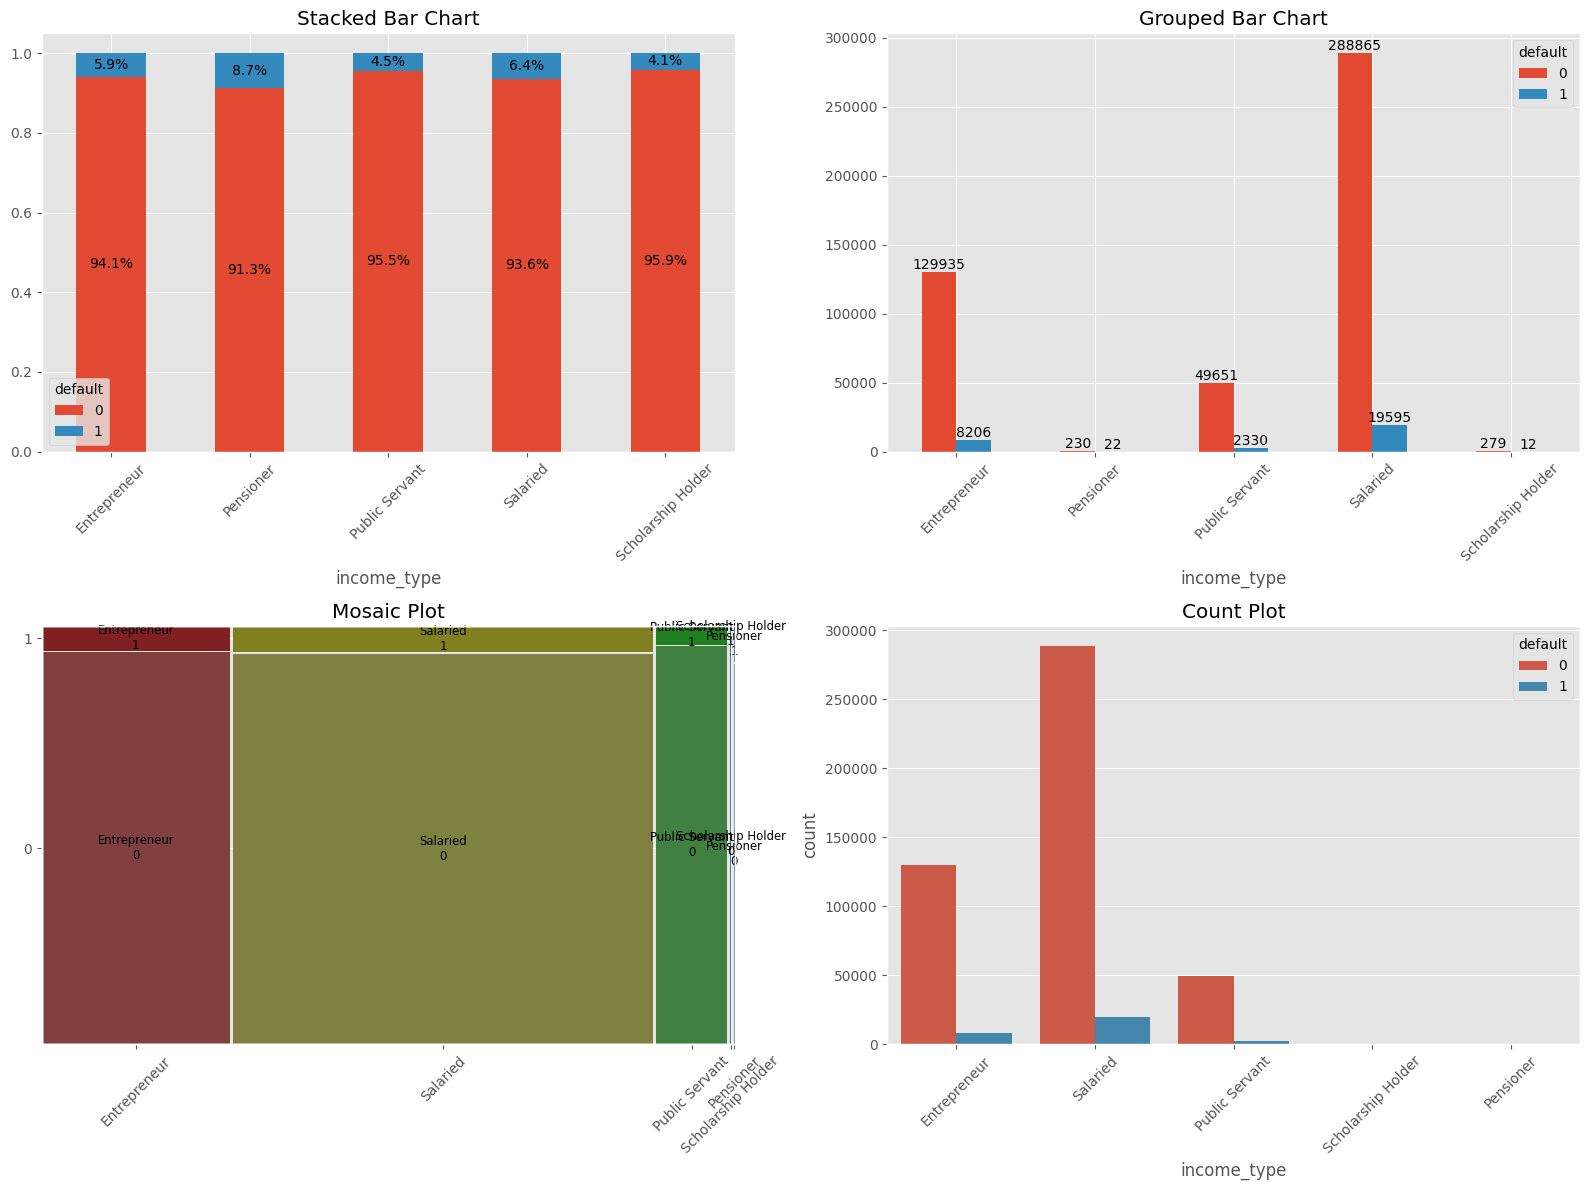

In [3611]:
biv_plot(df_train, x='income_type', y='default', threshold=15)

This analysis reveals that **Pensioners** and **Salaried** individuals have slightly higher default rates compared to **Public Servants** and **Scholarship Holders**, who exhibit lower default rates. The differences in default rates across income types can provide valuable insights into financial stability within each group.

Values that are too small, may be merged together in order to reduce potential biases towards discrepant values that may arise from a small sample value.

---

### **Default Rates by Education Level**

<Figure size 1000x600 with 0 Axes>

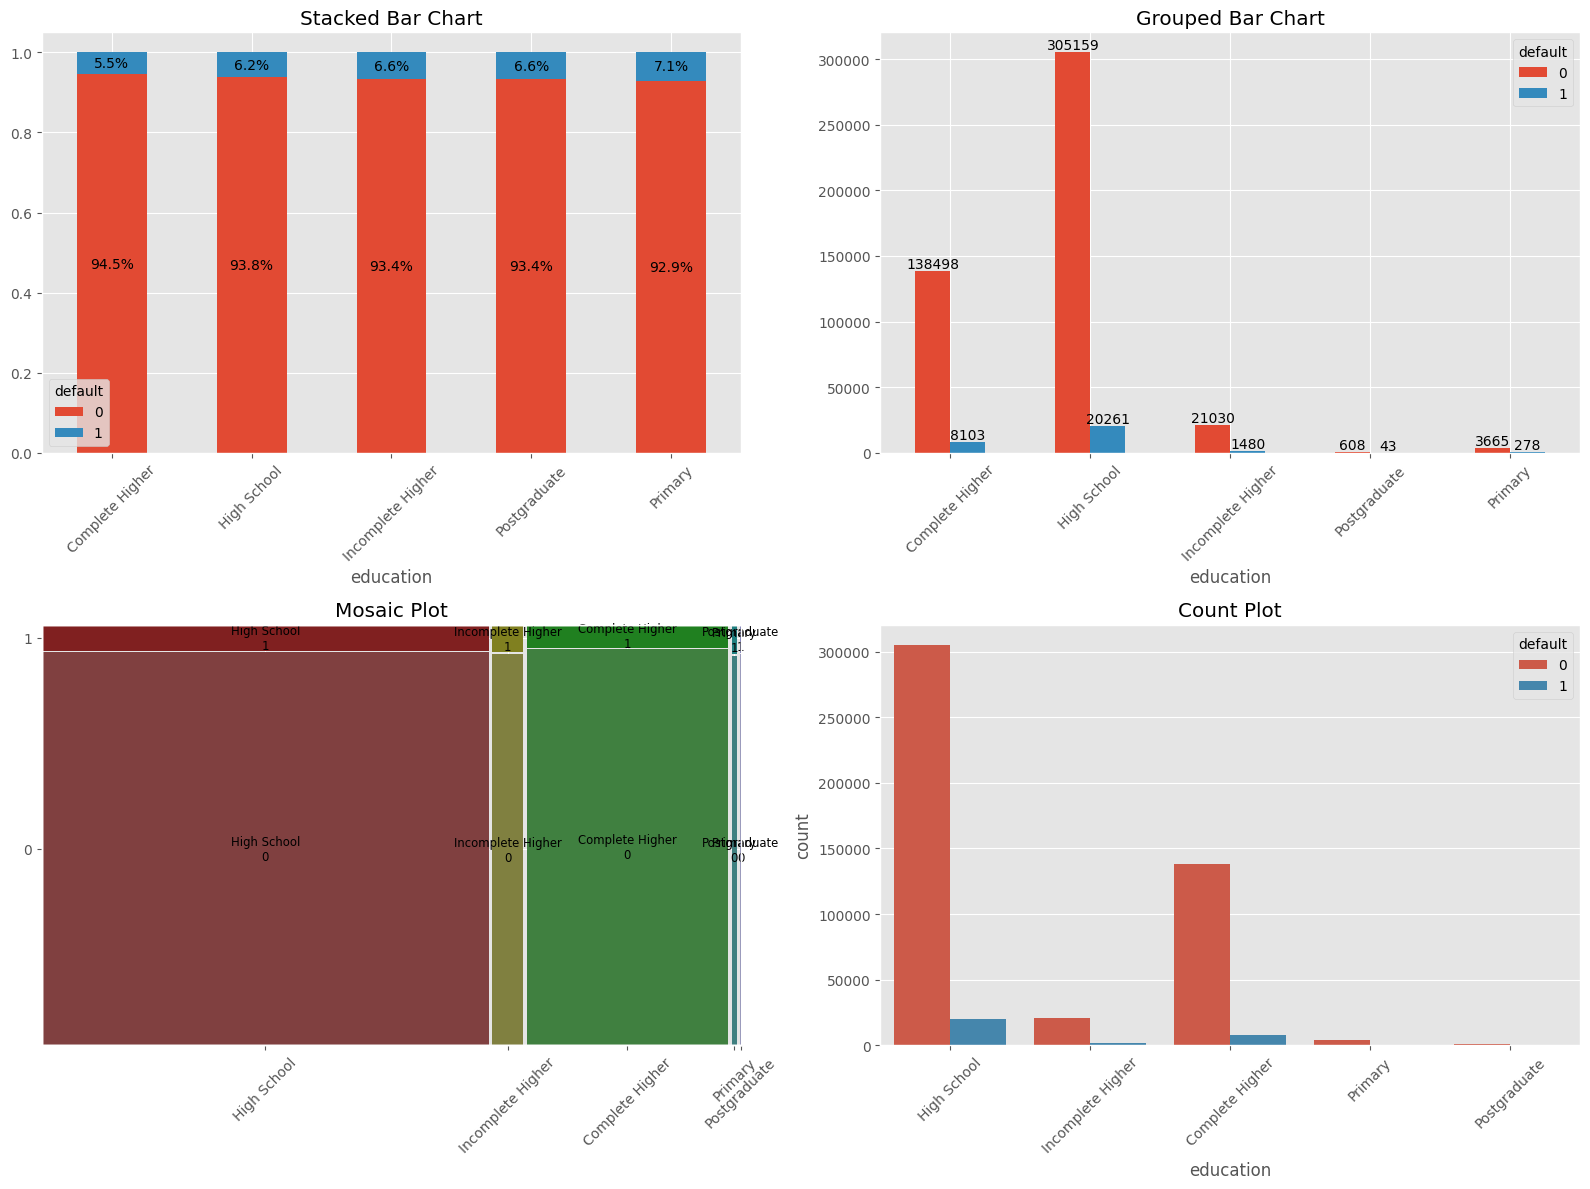

In [3616]:
biv_plot(df_train, x='education', y='default', threshold=15)


This analysis highlights that individuals with **Primary** education have the highest default rate, while those with a **Complete Higher** education have the lowest default rate. The data suggests a potential correlation between higher education levels and a lower likelihood of default.

---

### **Default Rates by Marital Status**

<Figure size 1000x600 with 0 Axes>

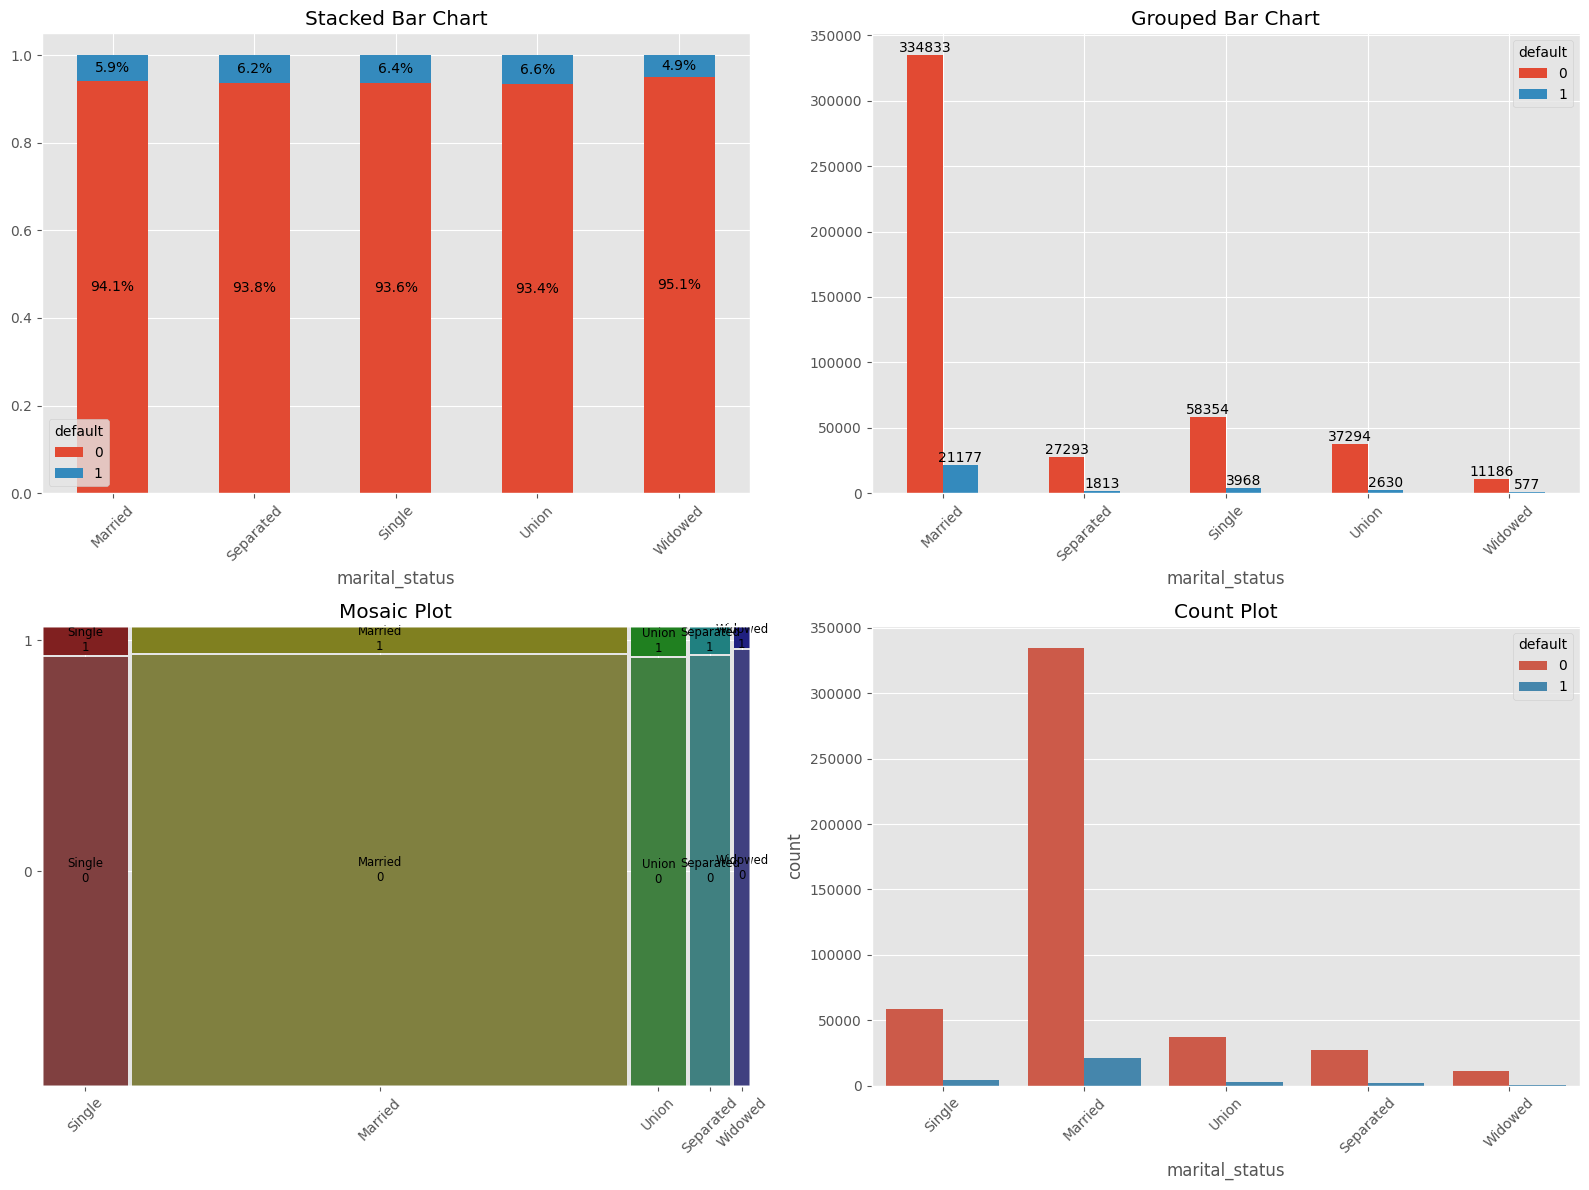

In [3620]:
biv_plot(df_train, x='marital_status', y='default', threshold=15)


The analysis shows slight variations in default rates across different marital statuses. Individuals in a **Union** and those who are **Separated** have slightly higher default rates, while **Widowed** individuals have the lowest default rate among the groups.

---

### **Default Rates by Residence Type**

<Figure size 1000x600 with 0 Axes>

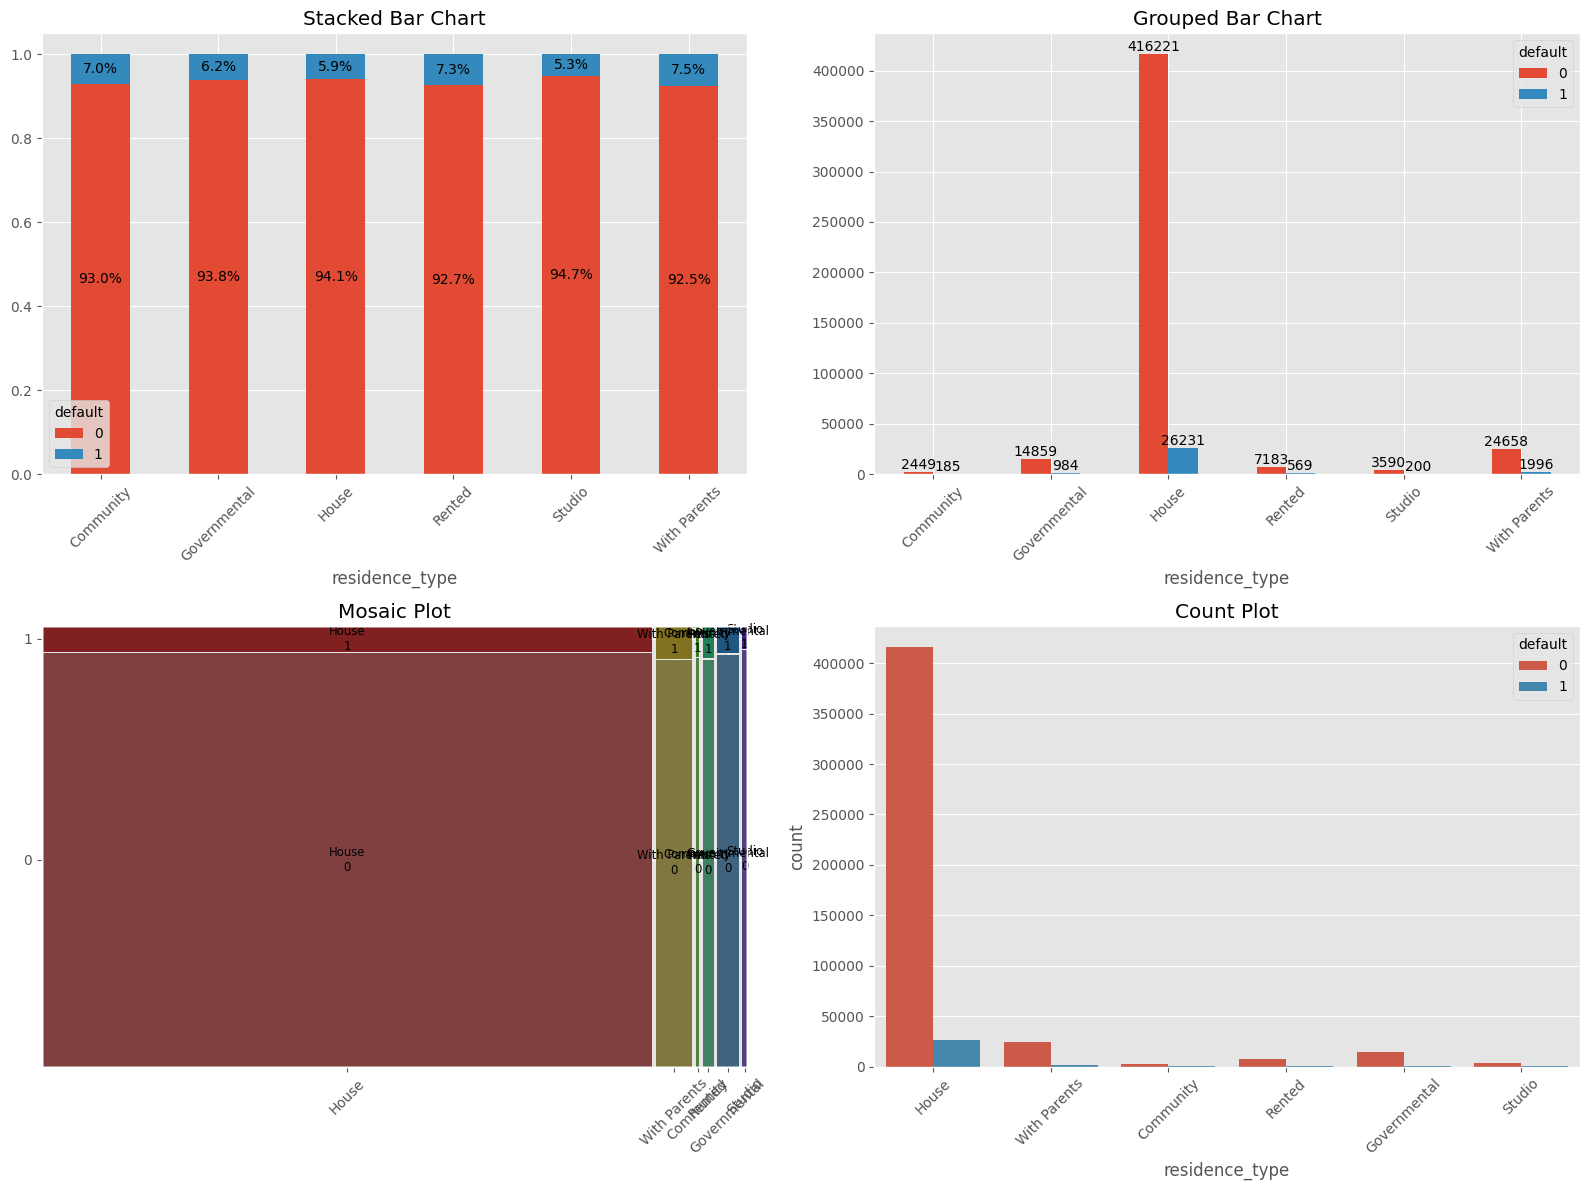

In [3624]:
biv_plot(df_train, x='residence_type', y='default', threshold=15)


This analysis shows that individuals living **With Parents** and in **Rented** properties have the highest default rates, while those living in **Studios** have the lowest default rate. The type of residence appears to have some correlation with the likelihood of default.

---

### **Default Rates by Number of Residents**

<Figure size 1000x600 with 0 Axes>

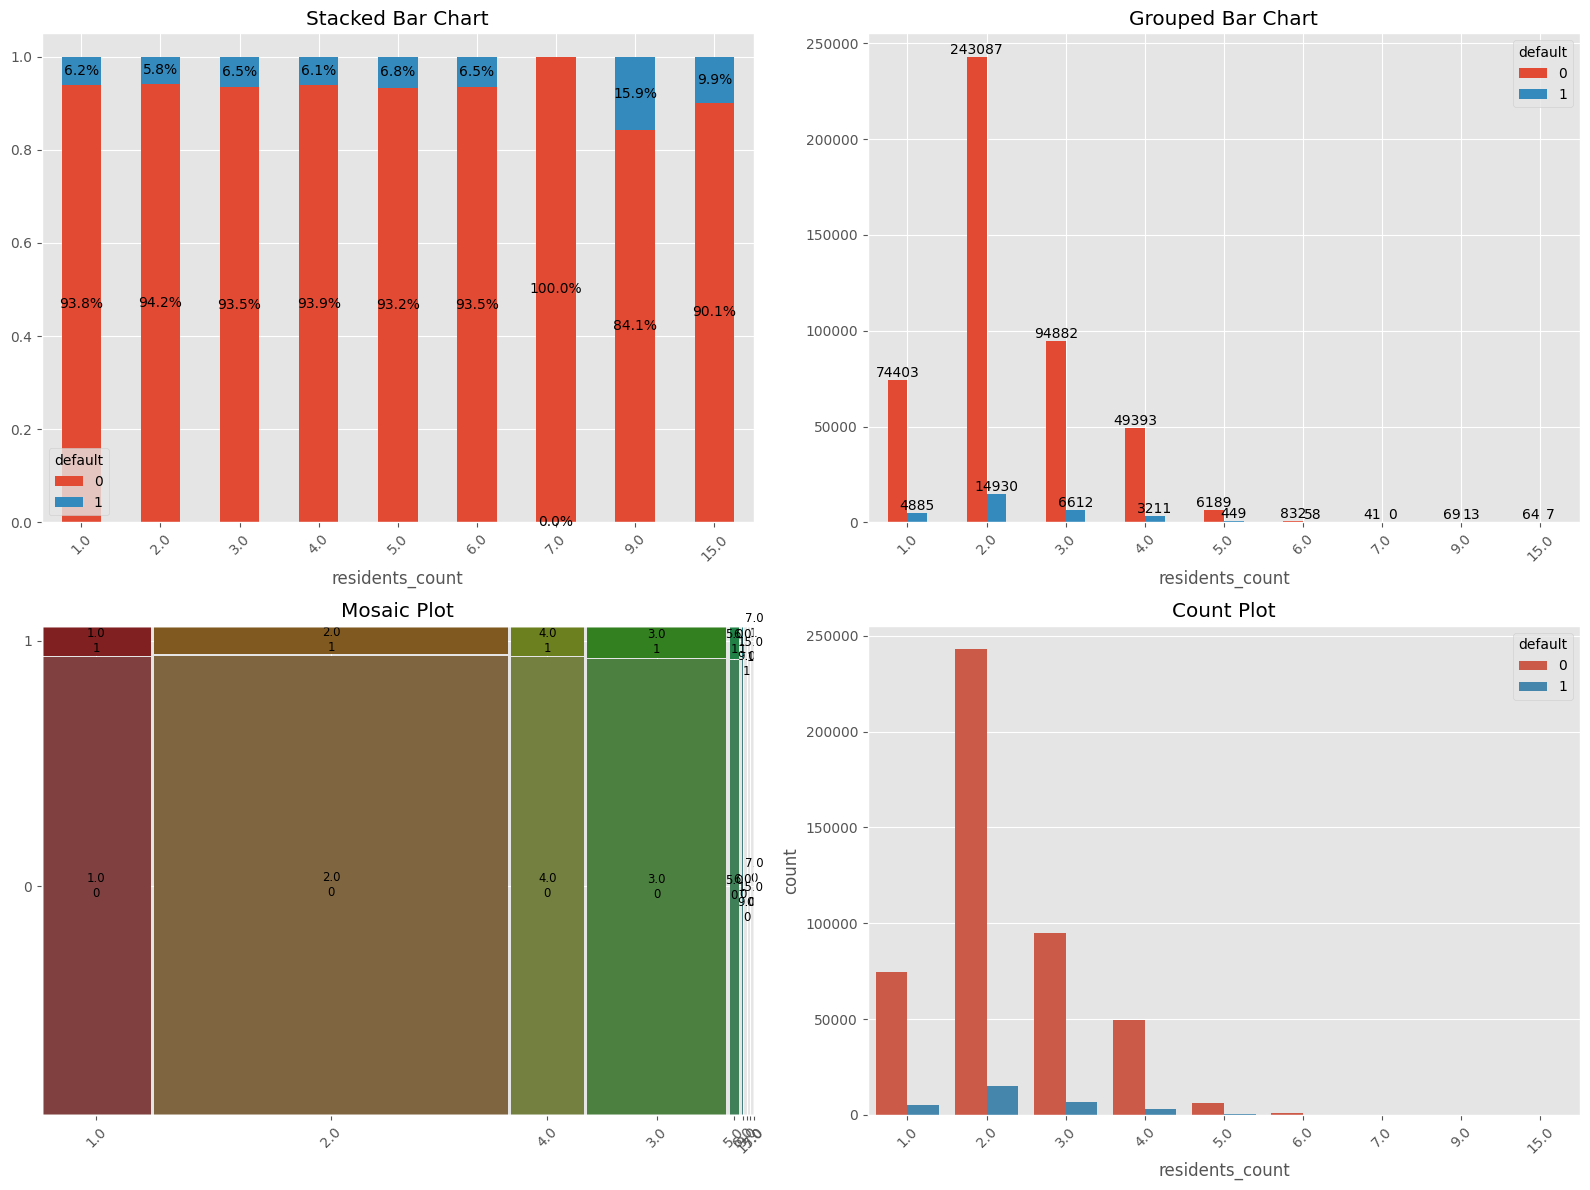

In [3628]:
biv_plot(df_train, x='residents_count', y='default', threshold=15)


### **Impact of Structural Zero**

The **7 Residents** category shows a **0.0% default rate**. This is an example of a **structural zero**, meaning that no defaults were observed in the data for households with exactly 7 residents. Structural zeros can occur due to data limitations or specific conditions within the dataset.

### **Implications of Structural Zero:**

1. **Model Bias**:
   - The presence of a structural zero can lead to bias in the model, particularly if the model interprets the lack of defaults in this category as a strong indicator of no risk, which may not be accurate in a broader context.

2. **Data Sparsity**:
   - Structural zeros often occur due to a lack of sufficient data in certain categories. This can make it difficult for the model to learn meaningful patterns from these categories, leading to unreliable predictions.

3. **Misinterpretation**:
   - It’s crucial to recognize structural zeros as artifacts of the dataset rather than definitive trends. Without proper interpretation, the model might give undue confidence to categories with structural zeros.

Overall, while the default rates generally increase with a higher number of residents, the structural zero for 7 residents requires careful consideration to avoid misleading the model's performance and interpretation.


---

### Default Rates by Age

<Figure size 1000x600 with 0 Axes>

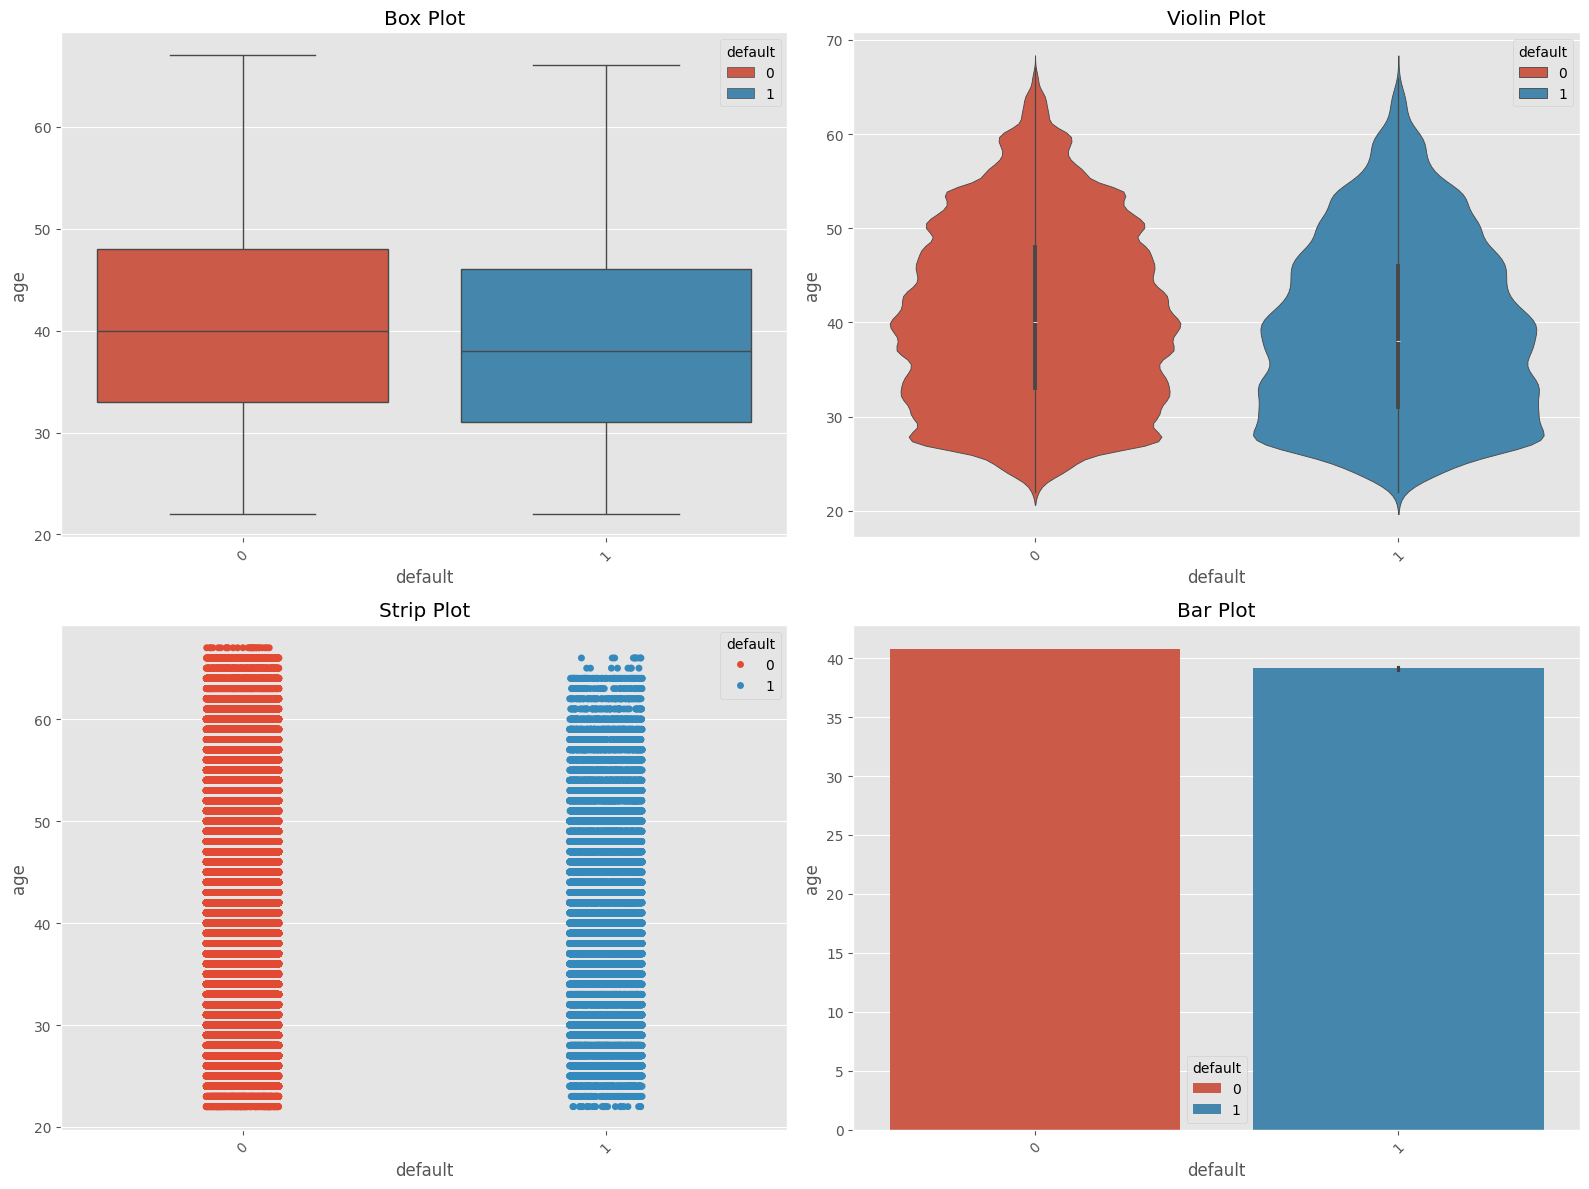

In [3632]:
biv_plot(df_train, x='age', y='default', threshold=15)

The plots suggest that age is not a decisive factor in determining whether an individual defaults, as the density distributions for both defaulted (True) and non-defaulted (False) individuals are nearly identical. However, the box plot reveals that individuals who defaulted tend to be slightly younger on average compared to those who did not default.


---

### Default Rates by Employment Time

<Figure size 1000x600 with 0 Axes>

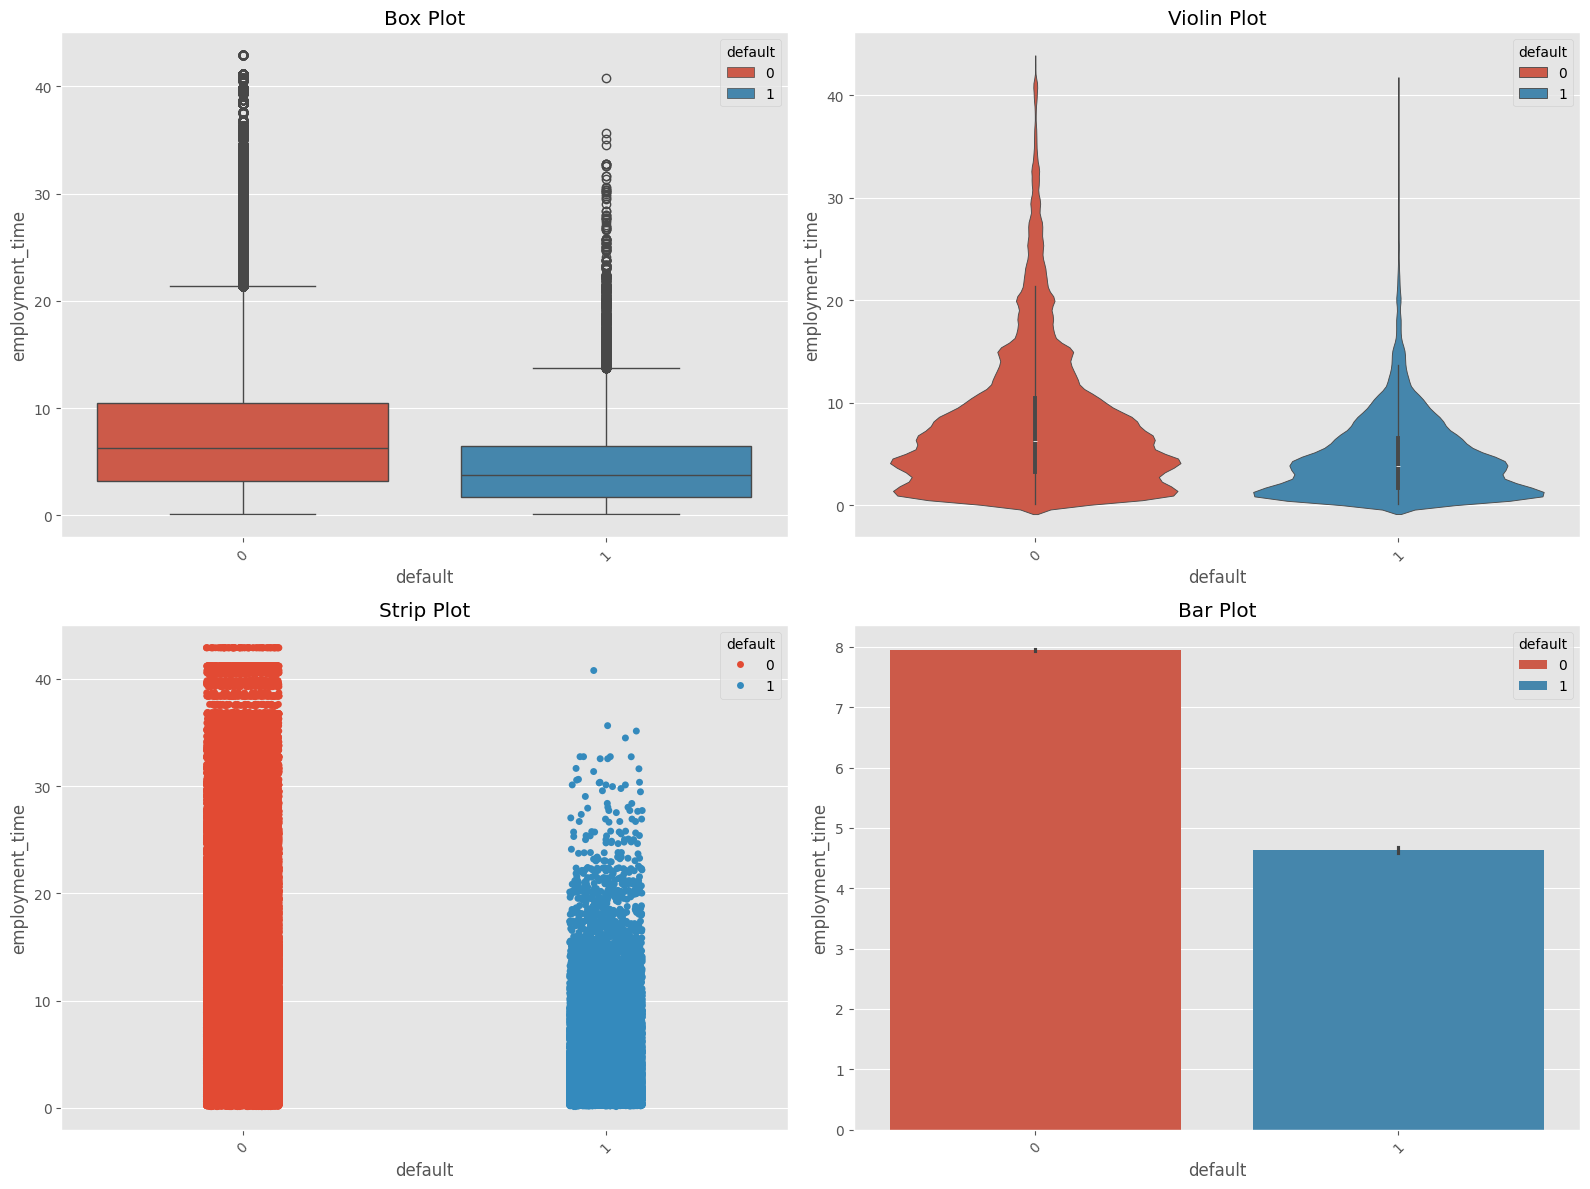

In [3636]:
biv_plot(df_train, x='employment_time', y='default', threshold=15)

50% of individuals who defaulted have between 0 and 6 years of employment time. Beyond this period, default rates tend to decrease, suggesting a correlation between longer employment time and better credit score outcomes.


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🧪 Data Preparation & Preprocessing</h1>
    <p style="font-size: 1.2em; text-align: center;">
        For this step, we are going to perform several operations in order to make our data fit to the Logistic Regression model we want to train.
    </p>
</div>

---


### Data Preparation and Preprocessing steps:

1. Cleaning Missing Values<br>
2. Treating Structural Zeros<br>
3. Treating Outliers<br>
4. Creating Dummies (One-Hot Encoding)<br>
5. Data Standarization<br>
6. Principal Component Analysis (PCA)<br>
7. Feature Selection
8. SMOTE

## 1. Cleaning Missing Values

We have already perfomed this step earlier defining the function "fill_missing_with_mean()"

---

Since we have already performed the first step, we are going to start with: </br>
## 2. Treating Structural Zeros

#### a) Defining a function to calculate the Information Value (IV)
The Information Value (IV) metric measures the predictive power of an independent variable in distinguishing between binary outcomes (e.g., good vs. bad credit). It helps identify the most significant predictors for a model, with higher IV values indicating stronger predictive capability.

 There is a rule-of-thumb that is widely accepted of how the value of a variable is reflected by its IV, see for example Naeem Siddiqi.  This is shown in the table below:

<div style="text-align: center;">
  <img src="https://github.com/PedroHang/Credit-Scoring-Project/blob/main/Images/IV.png?raw=true" alt="OOT" width="300"/>
</div>


#### We are defining a function that calculates Information Value (IV) based on WOE: </br>

<b>Weight of Evidence (WOE)</b> is a measure used in statistics and machine learning to quantify the predictive power of a feature by comparing the distribution of that feature across different classes

In [3649]:
def IV(x, y):
    # Create a crosstab to calculate the frequency distribution of x and y
    table = pd.crosstab(x, y, margins=True, margins_name='total')

    # Get the labels for the event and non-event categories
    event_label = table.columns[0]
    non_event_label = table.columns[1]

    # Calculate the percentage of events
    table['pct_event'] = table[event_label] / table.loc['total', event_label]
    table['event_proportion'] = table[event_label] / table.loc['total', event_label]

    # Calculate the percentage of non-events
    table['pct_non_event'] = table[non_event_label] / table.loc['total', non_event_label]

    # Calculate Weight of Evidence (WoE)
    table['woe'] = np.log(table.pct_event / table.pct_non_event)

    # Calculate the partial Information Value (IV)
    table['iv_partial'] = (table.pct_event - table.pct_non_event) * table.woe

    # Return the sum of the partial IVs as the total Information Value
    return table['iv_partial'].sum()

#### b) Creating a metadata table

Having this metadata allows us to properly preprocess our data, ensuring that it meets the requirements of logistic regression and improving the overall quality and interpretability of the model.

In [3652]:
metadata = pd.DataFrame(df_filled.dtypes, columns=['dtype'])
metadata['nmissing'] = df_filled.isna().sum()
metadata['unique_values'] = df_filled.nunique()
metadata['role'] = 'covariate'
metadata.loc['default','role'] = 'response'
metadata.loc['not_default','role'] = 'response'
metadata

,dtype,nmissing,unique_values,role
reference_date,datetime64[ns],0,15,covariate
gender,object,0,2,covariate
car_ownership,object,0,2,covariate
house_ownership,object,0,2,covariate
children_count,int64,0,8,covariate
income_type,object,0,5,covariate
education,object,0,5,covariate
marital_status,object,0,5,covariate
residence_type,object,0,6,covariate
age,int64,0,46,covariate


#### c) Calculating the Information Value for each of the variables

In [3654]:
for var in metadata[metadata.role=='covariate'].index:
    if  (metadata.loc[var, 'unique_values']>6):
        metadata.loc[var, 'IV'] = IV(pd.qcut(df_filled[var],5,duplicates='drop'), df_filled.default)
    else: 
        metadata.loc[var, 'IV'] = IV(df_filled[var], df_filled.default)

    
metadata

,dtype,nmissing,unique_values,role,IV
reference_date,datetime64[ns],0,15,covariate,0.337036
gender,object,0,2,covariate,0.001766
car_ownership,object,0,2,covariate,0.000030
house_ownership,object,0,2,covariate,0.011180
children_count,int64,0,8,covariate,0.000105
income_type,object,0,5,covariate,0.010465
education,object,0,5,covariate,0.003511
marital_status,object,0,5,covariate,0.002194
residence_type,object,0,6,covariate,0.004111
age,int64,0,46,covariate,0.027295


In [3655]:
metadata['IV'].sort_values(ascending=False)

income             1.140500
employment_time    0.351920
reference_date     0.337036
age                0.027295
house_ownership    0.011180
income_type        0.010465
residence_type     0.004111
education          0.003511
marital_status     0.002194
residents_count    0.002184
gender             0.001766
children_count     0.000105
car_ownership      0.000030
default                 NaN
not_default             NaN
Name: IV, dtype: float64

The Income variable has the highest Information Value (IV) at 1.06, which places it in the "suspicious" category according to our IV scale. This high IV suggests that Income is closely aligned with predicting whether a client defaults or not across most of the data. However, due to the presence of several outliers, the reliability of this variable is questionable. To enhance the trustworthiness of this variable, it is crucial to address and treat these outliers before using it for prediction.

Reference Date may not be used for prediction because it may lead to strong biases given that the dates have already been used to split the data.



#### d) Plotting graphs, Removing Structural Zeros and grouping similar Categories

Here we are defining a function that helps us with plotting the graphs that indicate the presence of Structural Zeros.

In [3659]:
def biv_discrete(var, df_filled):
    df_filled['not_default'] = 1 - df_filled.default
    g = df_filled.groupby(var)

    biv = pd.DataFrame({'qt_not_default': g['not_default'].sum(),
                        'qt_default': g['default'].sum(),
                        'default': g['default'].mean(),
                        var: g['default'].mean().index, 
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.default * (1 - biv.default) / biv.cont) ** .5
    biv['default_sup'] = biv.default + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['default_inf'] = biv.default - t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.default / (1 - biv.default))
    biv['logit_sup'] = np.log(biv.default_sup / (1 - biv.default_sup))
    biv['logit_inf'] = np.log(biv.default_inf / (1 - biv.default_inf))

    general_default_rate = df_filled.default.mean()
    general_woe = np.log(df_filled.default.mean() / (1 - df_filled.default.mean()))

    biv['woe'] = biv.logit - general_woe
    biv['woe_sup'] = biv.logit_sup - general_woe
    biv['woe_inf'] = biv.logit_inf - general_woe

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='superior limit')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='inferior limit')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat - .7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar(ax=ax[1])

    # Adding count labels on top of each bar
    for p in ax[1].patches:
        ax[1].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 10), 
                       textcoords='offset points')
    
    return biv


I am also making a copy of the df_filled so that we can treat the structural zeros without modifying our "original" dataframe.

In [3661]:
df_struc = df_filled.copy()

,qt_not_default,qt_default,default,income_type,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
income_type,,,,,,,,,,,,,,
Entrepreneur,159508,13204,0.076451,Entrepreneur,172712,0.000639,0.077704,0.077704,-2.491574,-2.473957,-2.473957,-0.011930,0.005687,0.005687
Pensioner,274,34,0.110390,Pensioner,308,0.017856,0.145526,0.145526,-2.086768,-1.770134,-1.770134,0.392877,0.709510,0.709510
Public Servant,61151,3771,0.058085,Public Servant,64922,0.000918,0.059884,0.059884,-2.786006,-2.753587,-2.753587,-0.306362,-0.273943,-0.273943
Salaried,354527,31213,0.080917,Salaried,385740,0.000439,0.081778,0.081778,-2.429950,-2.418434,-2.418434,0.049695,0.061211,0.061211
Scholarship Holder,346,15,0.041551,Scholarship Holder,361,0.010503,0.062207,0.062207,-3.138389,-2.713068,-2.713068,-0.658744,-0.233423,-0.233423


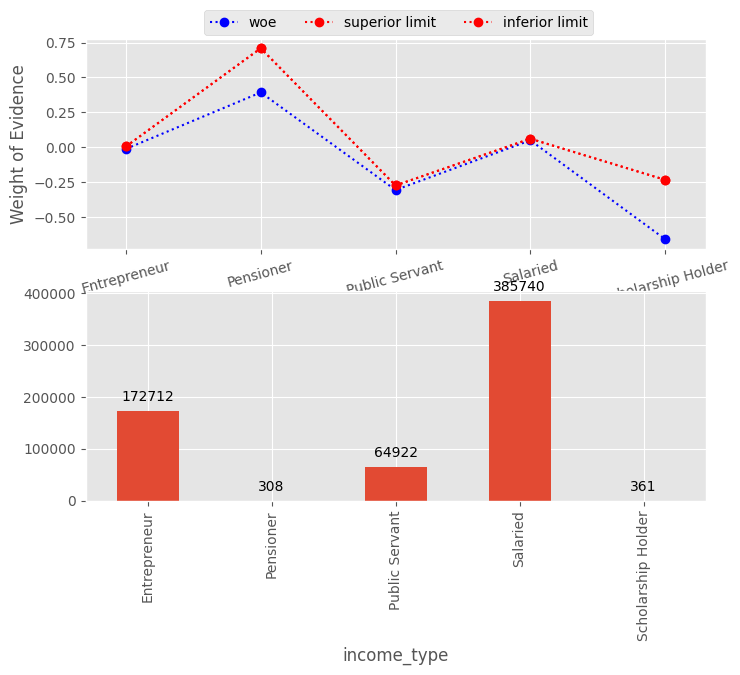

In [3662]:
biv_discrete('income_type', df_struc)

Here, we can observe that the 2 categories that contribute the most to a negative WOE "Failure of the event" are "Scholarship Holder" and "Public Servant". On the other side, they are also related in terms of conceptual similarity, as both indicate individuals with stable income sources provided by the Government.

#### Let's make the substitutions and plot the new graph:

,qt_not_default,qt_default,default,income_type,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
income_type,,,,,,,,,,,,,,
Entrepreneur,159508,13204,0.076451,Entrepreneur,172712,0.000639,0.077704,0.077704,-2.491574,-2.473957,-2.473957,-0.011930,0.005687,0.005687
Pensioner,274,34,0.110390,Pensioner,308,0.017856,0.145526,0.145526,-2.086768,-1.770134,-1.770134,0.392877,0.709510,0.709510
Salaried,354527,31213,0.080917,Salaried,385740,0.000439,0.081778,0.081778,-2.429950,-2.418434,-2.418434,0.049695,0.061211,0.061211
Scholarship/P.Servant,61497,3786,0.057994,Scholarship/P.Servant,65283,0.000915,0.059787,0.059787,-2.787678,-2.755325,-2.755325,-0.308034,-0.275680,-0.275680


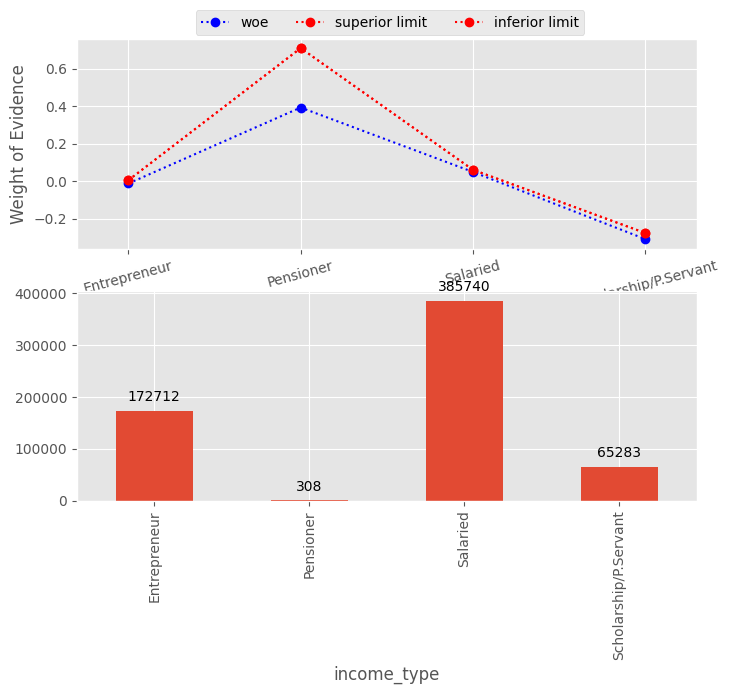

In [3665]:
df_struc.income_type.replace({'Scholarship Holder': 'Scholarship/P.Servant', 'Public Servant': 'Scholarship/P.Servant'}, inplace=True)
biv_discrete('income_type', df_struc)

C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_not_default,qt_default,default,residents_count,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
residents_count,,,,,,,,,,,,,,
1.0,91244,7813,0.078874,1.0,99057,0.000856,0.080552,0.080552,-2.457748,-2.434866,-2.434866,0.021896,0.044778,0.044778
2.0,298834,23871,0.073972,2.0,322705,0.000461,0.074875,0.074875,-2.527224,-2.514115,-2.514115,-0.047579,-0.034470,-0.034470
3.0,116197,10584,0.083483,3.0,126781,0.000777,0.085005,0.085005,-2.395944,-2.376206,-2.376206,0.083701,0.103438,0.103438
4.0,60702,5169,0.078472,4.0,65871,0.001048,0.080525,0.080525,-2.463297,-2.435233,-2.435233,0.016347,0.044412,0.044412
5.0,7593,689,0.083192,5.0,8282,0.003035,0.089141,0.089141,-2.399741,-2.324166,-2.324166,0.079904,0.155478,0.155478
6.0,1028,80,0.072202,6.0,1108,0.007776,0.087459,0.087459,-2.553344,-2.345067,-2.345067,-0.073699,0.134577,0.134577
7.0,52,0,0.000000,7.0,52,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,83,18,0.178218,9.0,101,0.038080,0.253767,0.253767,-1.528469,-1.078622,-1.078622,0.951176,1.401022,1.401022
15.0,73,13,0.151163,15.0,86,0.038627,0.227963,0.227963,-1.725510,-1.219851,-1.219851,0.754134,1.259793,1.259793


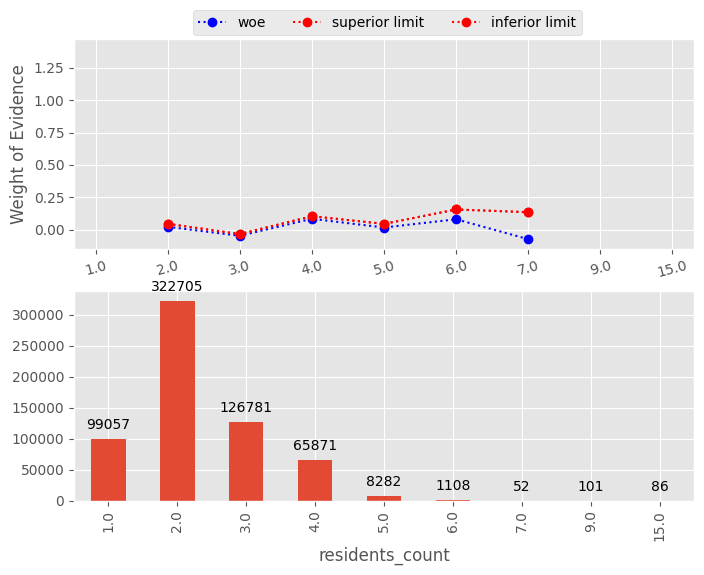

In [3666]:
biv_discrete('residents_count', df_struc)

Due to small sample sizing, we are grouping all categories from 6 and beyond into one single category, this way we can address the structural zero and small sample sizes.

,qt_not_default,qt_default,default,residents_count,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
residents_count,,,,,,,,,,,,,,
1.0,91244,7813,0.078874,1.0,99057,0.000856,0.080552,0.080552,-2.457748,-2.434866,-2.434866,0.021896,0.044778,0.044778
2.0,298834,23871,0.073972,2.0,322705,0.000461,0.074875,0.074875,-2.527224,-2.514115,-2.514115,-0.047579,-0.034470,-0.034470
3.0,116197,10584,0.083483,3.0,126781,0.000777,0.085005,0.085005,-2.395944,-2.376206,-2.376206,0.083701,0.103438,0.103438
4.0,60702,5169,0.078472,4.0,65871,0.001048,0.080525,0.080525,-2.463297,-2.435233,-2.435233,0.016347,0.044412,0.044412
5.0,7593,689,0.083192,5.0,8282,0.003035,0.089141,0.089141,-2.399741,-2.324166,-2.324166,0.079904,0.155478,0.155478
6.0,1028,80,0.072202,6.0,1108,0.007776,0.087459,0.087459,-2.553344,-2.345067,-2.345067,-0.073699,0.134577,0.134577
>6,208,31,0.129707,>6,239,0.021733,0.172520,0.172520,-1.903551,-1.567869,-1.567869,0.576094,0.911775,0.911775


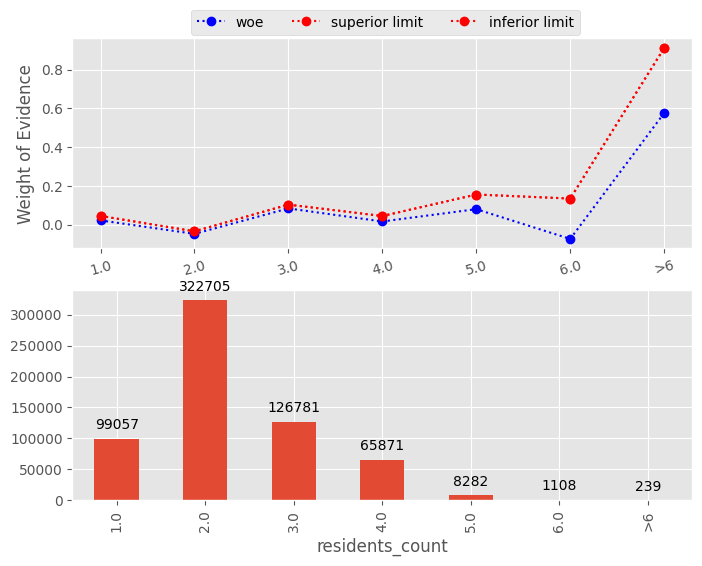

In [3668]:
df_struc['residents_count'] = df_struc['residents_count'].astype(float)
df_struc['residents_count'] = df_struc['residents_count'].apply(lambda x: x if x <= 6 else '>6')
df_struc['residents_count'] = df_struc['residents_count'].astype(str)
biv_discrete('residents_count', df_struc)

#### Defining the continuous function 

In [3670]:
def biv_continuous(var, ncat, df):
    df['not_default'] = 1 - df.default
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    
    # Explicitly set observed=False to silence the warning
    g = df.groupby(cat_srs, observed=False)

    biv = pd.DataFrame({'qt_not_default': g['not_default'].sum(),
                        'qt_default': g['default'].sum(),
                        'default': g['default'].mean(), 
                        var: g[var].mean(), 
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.default * (1 - biv.default) / biv.cont) ** .5
    biv['default_sup'] = biv.default + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['default_inf'] = biv.default - t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.default / (1 - biv.default))
    biv['logit_sup'] = np.log(biv.default_sup / (1 - biv.default_sup))
    biv['logit_inf'] = np.log(biv.default_inf / (1 - biv.default_inf))

    general_default_rate = df.default.mean()
    general_woe = np.log(df.default.mean() / (1 - df.default.mean()))

    biv['woe'] = biv.logit - general_woe
    biv['woe_sup'] = biv.logit_sup - general_woe
    biv['woe_inf'] = biv.logit_inf - general_woe

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='superior limit')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='inferior limit')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    
    return None


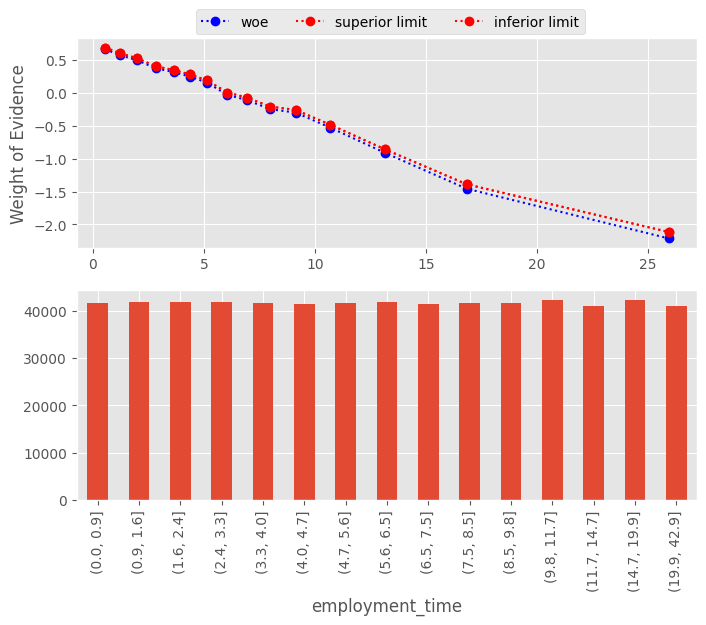

In [3671]:
biv_continuous('employment_time', 15, df_struc)

Dealing with negative values

In [3673]:
df_struc.loc[df_struc['employment_time']<0,'employment_time'] = -1

We have successfully treated all structural zeros from our dataset. Although there are more categories that could be grouped together, the variables under which they are present are not significant enough for our modelling task.

---

## 3. Treating Outliers

We are now going to define a technique that addresses and treats outliers. First, we have to plot a visualization in which we can see the strength of such values.

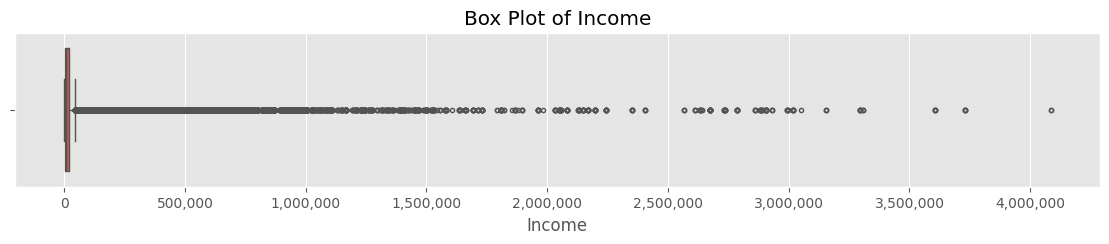

In [3678]:
plt.figure(figsize=(14, 2))
sns.boxplot(
    x=df_struc['income'], 
    flierprops=dict(marker='o', markersize=3)
)
plt.title('Box Plot of Income')
plt.xlabel('Income')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

We can notice how strong these outliers are and how they may influence in our modelling phase. Here we will be implementing a function that removes outliers based on the <b>Z-score</b>.

The **Z-score** is a statistical measure that indicates how many standard deviations a data point is from the mean of the dataset. It's calculated using the formula:


$$
\
\Huge Z = \frac{X - \mu}{\sigma}
\
$$

where $X$ is the data point, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The lenght of the dataframe before removing the outliers is the following

In [3682]:
print(df_struc.shape)

(624043, 15)


The function below removes outliers from a DataFrame based on a specified Z-score threshold, returning a cleaned DataFrame while printing the number of rows removed per column.

In [3684]:
def remove_outliers_zscore(df, z_thresh=3.0):
    # Copy the DataFrame to avoid modifying the original one
    df_cleaned = df.copy()

    # Initialize a dictionary to store the number of removed rows per column
    removal_counts = {}

    # Calculate Z-scores for each numeric column
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        z_scores = np.abs(stats.zscore(df_cleaned[column]))

        # Identify rows to remove based on the Z-score threshold
        outliers = z_scores > z_thresh
        num_outliers = outliers.sum()
        
        if num_outliers > 0:
            # Record the number of rows removed for this column
            removal_counts[column] = num_outliers

        # Remove the outliers from the DataFrame
        df_cleaned = df_cleaned[~outliers]

    # Print the number of rows removed per column
    for column, count in removal_counts.items():
        print(f"Removed {count} rows based on outliers in column '{column}'")

    # Reset the index of the cleaned DataFrame
    df_cleaned.reset_index(drop=True, inplace=True)
    
    return df_cleaned

#### We are removing the values that are 3 standard deviations from the mean.

In [3686]:
remove_outliers_zscore(df_struc, 4.0)

Removed 1347 rows based on outliers in column 'children_count'
Removed 3080 rows based on outliers in column 'employment_time'
Removed 6288 rows based on outliers in column 'income'


,reference_date,gender,car_ownership,house_ownership,children_count,income_type,education,marital_status,residence_type,age,employment_time,residents_count,income,default,not_default
0,2015-01-01,F,No,No,0,Entrepreneur,High School,Single,House,43,6.873973,1.0,2515.39,0,1
1,2015-01-01,F,Yes,Yes,0,Salaried,High School,Married,House,35,4.526027,2.0,3180.19,0,1
2,2015-01-01,F,No,No,2,Salaried,High School,Married,House,31,0.243836,4.0,1582.29,0,1
3,2015-01-01,F,No,No,0,Salaried,High School,Married,House,54,12.772603,2.0,13721.17,0,1
4,2015-01-01,F,Yes,No,0,Salaried,Incomplete Higher,Single,House,31,8.432877,1.0,2891.08,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613323,2016-03-01,F,No,Yes,0,Entrepreneur,Complete Higher,Married,House,51,13.298630,2.0,15315.94,0,1
613324,2016-03-01,M,No,Yes,0,Entrepreneur,Complete Higher,Married,House,48,3.038356,2.0,2109.99,0,1
613325,2016-03-01,M,Yes,No,2,Salaried,High School,Married,House,43,10.375342,4.0,649.06,1,0
613326,2016-03-01,F,No,Yes,0,Salaried,High School,Widowed,House,56,13.780822,1.0,4216.72,1,0


In [3687]:
df_outl = remove_outliers_zscore(df_struc, 6.0)

Removed 187 rows based on outliers in column 'children_count'
Removed 2563 rows based on outliers in column 'income'


---

## 4. Creating Dummies (One-Hot Encoding)

One-hot encoding is a technique that converts categorical variables into a binary format, creating new columns for each unique category with values of 0 or 1. It's useful in modeling because many machine learning algorithms require numerical input, and one-hot encoding allows categorical data to be represented in a way that these algorithms can process effectively, avoiding any ordinal relationships that don't actually exist in the data.

In [3691]:
def one_hot_encode(df):
    df_encoded = pd.get_dummies(df, drop_first=True)

    return df_encoded

Now we got our dataframe successfully one-hot encoded.

In [3693]:
df_1hot = one_hot_encode(df_outl)

In [3694]:
df_1hot.columns

Index(['reference_date', 'children_count', 'age', 'employment_time', 'income',
       'default', 'not_default', 'gender_M', 'car_ownership_Yes',
       'house_ownership_Yes', 'income_type_Pensioner', 'income_type_Salaried',
       'income_type_Scholarship/P.Servant', 'education_High School',
       'education_Incomplete Higher', 'education_Postgraduate',
       'education_Primary', 'marital_status_Separated',
       'marital_status_Single', 'marital_status_Union',
       'marital_status_Widowed', 'residence_type_Governmental',
       'residence_type_House', 'residence_type_Rented',
       'residence_type_Studio', 'residence_type_With Parents',
       'residents_count_2.0', 'residents_count_3.0', 'residents_count_4.0',
       'residents_count_5.0', 'residents_count_6.0', 'residents_count_>6'],
      dtype='object')

In [3695]:
len(df_1hot.columns)

32

---

## 5. Data Standarization

Standarizing a dataset involves scaling the features so that they have a common range, typically between 0 and 1 (Normalization), or so that they have a mean of 0 and a standard deviation of 1 (Standarization). This is needed because many machine learning algorithms perform better or converge faster when the input features are on a similar scale, preventing features with larger ranges from dominating the learning process. Standarization also helps in improving the stability and performance of models.

##### Let's start by creating a list of the continuous variables, given that we only want to standarize them:

In [3700]:
continuous_columns = ['age', 'income', 'employment_time', 'children_count']

##### Separating the one-hot encoded dataframe (with the response variables) from the continuous variables:

In [3702]:
dummy_columns = [col for col in df_1hot.columns if col not in continuous_columns + ['not_default', 'default']]

##### Setting the scaler and fitting the data to it:

In [3704]:
scaler = StandardScaler()
df_scaled_continuous = pd.DataFrame(scaler.fit_transform(df_1hot[continuous_columns]), columns=continuous_columns)

##### Joining the variables back together

In [3706]:
df_combined = pd.concat([df_scaled_continuous, df_1hot[dummy_columns].reset_index(drop=True), df_1hot[['not_default', 'default']].reset_index(drop=True)], axis=1)

In [3707]:
df_combined.head(3)

,age,income,employment_time,children_count,reference_date,gender_M,car_ownership_Yes,house_ownership_Yes,income_type_Pensioner,income_type_Salaried,...,residence_type_Studio,residence_type_With Parents,residents_count_2.0,residents_count_3.0,residents_count_4.0,residents_count_5.0,residents_count_6.0,residents_count_>6,not_default,default
0,0.255102,-0.416413,-0.119006,-0.672370,2015-01-01,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,0
1,-0.600919,-0.402028,-0.480687,-0.672370,2015-01-01,False,True,True,False,True,...,False,False,True,False,False,False,False,False,1,0
2,-1.028930,-0.436603,-1.140322,1.958806,2015-01-01,False,False,False,False,True,...,False,False,False,False,True,False,False,False,1,0


#### Data Split

Here, we are once again separating all of the data into <b>Train</b> and <b>Out-of-time</b> (Test).

In [3710]:
df_train = df_combined[df_combined['reference_date'] <= '2015-12-31']
df_oot = df_combined[df_combined['reference_date'] >= '2016-01-01']

##### The 'not_default', 'reference_date' and 'income' variables are not useful anymore, therefore we can remove them:

In [3712]:
df_train = df_train.drop(columns=['not_default', 'reference_date', 'income'], inplace=False)
df_oot = df_oot.drop(columns=['not_default', 'reference_date', 'income'], inplace=False)

The decision to remove 'Income' from the model was driven by the presence of significant outliers in this variable. These outliers could distort the model's performance, leading to unreliable predictions. While it is possible to address outliers by removing them, doing so would significantly reduce the size of our dataset, that could compromise the generalizability of the model. Therefore, excluding 'Income' ensures that we maintain the integrity of the dataset while avoiding the complications introduced by these extreme values.


---

## 6. Principal Component Analysis (PCA)

### Dimensionality Reduction & PCA

Dimensionality reduction is the process of reducing the number of input variables in a dataset, simplifying models and mitigating overfitting. **PCA (Principal Component Analysis)** is useful as it identifies the most important features by transforming the data into orthogonal components, preserving variance while minimizing redundancy. However, the data will change as it is projected into a new space, often losing its original feature interpretability, making the transformed data less recognizable but more efficient for analysis.
.


##### Below, we are choosing the number of components to keep (5), applying PCA, and then using the standarized data from the previous step.

In [3718]:
X = df_train.drop(columns=['default'])
y = df_train['default']  # This is the response variable

In [3719]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [3720]:
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

In [3721]:
df_train_final = pd.concat([df_pca, y.reset_index(drop=True)], axis=1)

In [3722]:
df_train_final.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,default
0,0.483240,-0.423387,-0.033080,-0.757167,0.035428,0.498718,-0.733399,-0.340497,0.479624,0.656417,0
1,-0.040419,-0.962385,-0.360196,0.290830,-0.335350,-0.422866,0.513909,-0.107023,-0.536102,0.465095,0
2,-2.375013,0.495401,0.683346,-0.479996,-0.750341,0.751901,0.517533,0.006196,0.131423,0.272517,0
3,1.840042,0.287824,0.326882,-0.140196,-0.577320,0.642215,0.047941,0.139022,-0.157445,-0.075770,0
4,-0.357716,-0.515433,-1.198842,0.049388,0.036109,0.118660,-0.565147,1.012665,0.152975,0.933723,0
5,0.881036,2.467841,-0.791076,-0.385051,-0.092516,-0.637828,-0.499834,0.730420,-0.270670,-0.491120,0
6,-1.354075,1.653469,0.345139,-0.063430,0.946857,-0.106575,0.618545,0.292402,-0.000562,0.528229,0
7,0.455940,-0.500339,-0.507599,0.281636,-0.112313,-0.025416,0.136568,0.544536,0.611716,-0.641697,0
8,-0.957372,2.309123,-0.179478,-0.103155,1.216141,-0.071363,0.593243,0.134861,0.041326,0.481629,0
9,0.503507,-1.177183,0.743573,-0.718689,0.714392,-0.062809,0.441538,0.245593,-0.092779,-0.405033,0


---

In [3724]:
X_ = df_oot.drop(columns=['default'])
y_ = df_oot['default']  # This is the response variable
pca_ = PCA(n_components=10)
X_pca_ = pca_.fit_transform(X_)
df_pca_ = pd.DataFrame(data=X_pca_, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_oot_final = pd.concat([df_pca_, y_.reset_index(drop=True)], axis=1)

In [3725]:
df_oot_final.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,default
0,-1.459397,1.444704,0.646123,0.158235,0.232572,-0.249887,0.682926,0.778098,-0.057031,0.532411,1
1,1.588674,-0.296538,0.880174,-0.239556,-0.461812,-0.199400,0.310121,0.026277,-0.087078,-0.081601,0
2,-0.616625,0.661576,0.151306,0.805548,-0.222531,-0.622951,-0.551996,-0.307247,-0.427809,-0.327134,0
3,-1.607235,-0.175328,0.002017,-0.575972,-0.762437,-0.208020,-0.448837,-0.166809,-0.507360,-0.245070,0
4,-0.559585,-0.833738,-1.327027,1.003351,-0.440907,0.399389,0.145928,-0.227587,-0.089254,0.030610,0
5,-0.109500,0.296537,1.516489,0.166553,-0.409016,-0.472847,-0.688434,-0.178063,0.109594,-0.722440,0
6,0.211258,1.671589,-0.531827,0.543008,1.069724,-0.535792,-0.618143,0.126175,-0.244843,-0.637305,0
7,-0.517993,0.318572,0.821547,-0.497102,-0.572594,-0.510180,-0.428108,-0.072916,-0.439476,-0.230538,0
8,-0.541065,-1.154054,-0.723534,0.189467,0.147553,-0.461882,0.611072,0.640301,-0.450552,0.263134,0
9,1.878770,0.966860,-0.978967,0.044533,1.319681,-0.200628,0.330921,0.209562,-0.282366,0.124533,0


We have successfully applied PCA Dimensionality Reduction to both our dataframes.

---

## 7. Feature Selection

### Cumulative Explained Variance by Principal Components

In this section, we visualize the cumulative explained variance as a function of the number of principal components. The graph below shows how much of the total variance in the data is explained as we include more principal components. 

The cumulative sum of explained variance helps us decide how many components to keep: ideally, we look for an "elbow" shape in the graph, where the curve starts to level off. This indicates that additional components contribute less to explaining the variance, and we might be able to reduce the dimensionality of our dataset without losing much informatioIver, in our case, the graph shows a smooth curve without a clear "elbow." This suggests that each component contributes incrementally to explaining the variance, making it less effective to perform feature selectionsolely oncriteriaterion. Therefore, retaining more components might be necessary to capture the variability in the data, as no single point in the graph indicates a natural cutoff for reducing dimensionality.


In [3730]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

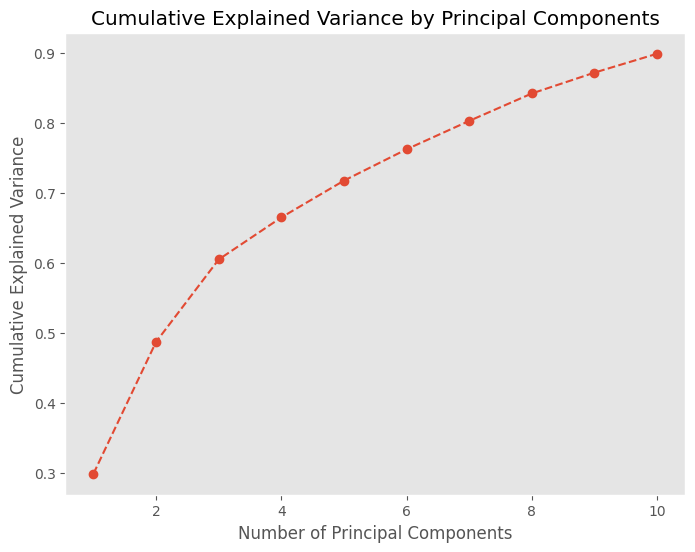

In [3731]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

## 8. SMOTE



**SMOTE (Synthetic Minority Over-sampling Technique)** generates synthetic samples for the minority class to balance the dataset. It does this by selecting a minority class instance and finding its k-nearest neighbors. New synthetic samples are created by interpolating between the selected instance and its neighbors along the line segment connecting them. This approach enriches the minority class without duplicating existing data, leading to a more balanced dataset for model training.


In [3734]:
df_train_final_X = df_train_final.drop(columns=['default'])
df_train_final_y = df_train_final['default']

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(df_train_final_X, df_train_final_y)

df_train_final = pd.concat([pd.DataFrame(X_train_smote, columns=df_train_final_X.columns), pd.DataFrame(y_train_smote, columns=['default'])], axis=1)

# Check the new balance in the training set after SMOTE
print(df_train_final['default'].value_counts())

default
0    466282
1    466282
Name: count, dtype: int64


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🧠 Modelling</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this step, we will train a <b>Logistic Regression</b> model using the data we have prepared. Our goal is to leverage the insights gained from our dimensionality reduction and feature engineering processes to build a robust model that can effectively predict the target variable.
    </p>
</div>

---


### Logistic Regression

Logistic regression is a statistical method used for binary classification that models the probability of a given outcome. Unlike linear regression, which predicts a continuous value, logistic regression predicts the probability of a categorical outcome (0 or 1). It does this by applying the logistic function to a linear combination of input features, resulting in a probability value between 0 and 1. Logistic regression is widely used in various fields such as medicine, finance, and social sciences to model binary outcomes.

### Logistic Regression Formula

The logistic regression model can be represented by the following formula:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_nX_n)}}
$$

#### Explanation of the Components:
- **$P(Y = 1 \mid X)$**: The probability that the outcome $Y$ is 1 given the input features $X$.
- **$\beta_0$**: The intercept term, representing the baseline log-odds of the outcome when all input features are 0.
- **$\beta_1, \beta_2, \cdots, \beta_n$**: The coefficients corresponding to the input features $X_1, X_2, \cdots, X_n$. These coefficients represent the change in the log-odds of the outcome for a one-unit increase in the corresponding feature.
- **$X_1, X_2, \cdots, X_n$**: The input features or independent variables.
- **$e$**: The base of the natural logarithm, approximately equal to 2.71828.

The formula transforms the linear combination of the features into a probability using the logistic (sigmoid) function, making logistic regression a powerful tool for classification tasks.


Down below, we are defining the formula we are going to use in order to train the model. Note that 'default' represents the response variable, while the values after the '~' represents the X variables:

In [3738]:
formula = '''
    default ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10
'''

Splitting data into X and y

In [3775]:
df_train_final_X = df_train_final.drop(columns=['default'])
df_train_final_y = df_train_final['default']

In [3777]:
df_oot_final_X = df_oot_final.drop(columns=['default'])
df_oot_final_y = df_oot_final['default']

The code below fits a logistic regression model using the specified formula and training data (df_train_final) with a binomial family (appropriate for binary outcomes), and then generates a summary of the model’s results:

In [3809]:
model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced')
model.fit(df_train_final_X, df_train_final_y)

LogisticRegression(C=0.5, class_weight='balanced')

Lastly, we are going to display some important metrics in order to evualuate the power of our model.

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">📋 Evaluation</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this step, we will be evaluating the Logistic Regression model trained earlier in respect to <b>Accuracy</b>, <b>KS</b> and <b>Gini</b>
    </p>
</div>

---


## Accuracy:

**Accuracy** is the proportion of correct predictions (both true positives and true negatives) made by the logistic regression model out of the total predictions.


In [3831]:
predictions_train = model.predict(df_train_final_X)

# Convert probabilities to binary outcomes (threshold of 0.5)
predicted_classes_train = (predictions_train >= 0.5).astype(int)
accuracy_train = accuracy_score(df_train_final_y, predictions_train)
print(f'Accuracy for the Train set: {accuracy_train * 100:.2f}%')

Accuracy for the Train set: 61.95%


In [3833]:
predictions_oot = model.predict(df_oot_final_X)

# Convert probabilities to binary outcomes (threshold of 0.5)
predicted_classes_oot = (predictions_oot >= 0.5).astype(int)
accuracy_oot = accuracy_score(df_oot_final_y, predicted_classes_oot)
print(f'Accuracy for the Out-of-Time set: {accuracy_oot * 100:.2f}%')

Accuracy for the Out-of-Time set: 57.16%


## Confusion Matrix

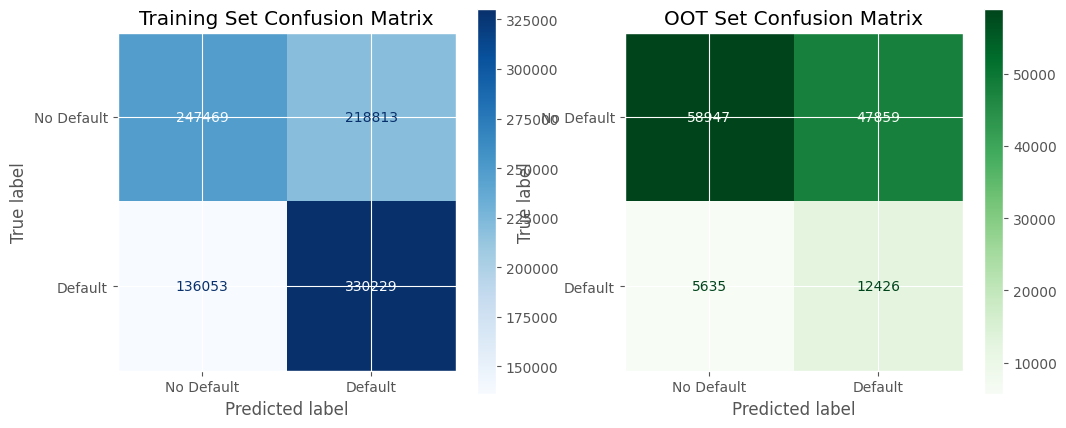

In [3835]:
# Confusion matrix for the training set
cm_train = confusion_matrix(df_train_final_y, predictions_train >= 0.5)
# Confusion matrix for the OOT set
cm_oot = confusion_matrix(df_oot_final_y, predictions_oot >= 0.5)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set confusion matrix
ConfusionMatrixDisplay(cm_train, display_labels=['No Default', 'Default']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Training Set Confusion Matrix')

# OOT set confusion matrix
ConfusionMatrixDisplay(cm_oot, display_labels=['No Default', 'Default']).plot(ax=ax[1], cmap='Greens')
ax[1].set_title('OOT Set Confusion Matrix')

plt.show()


## KS

The <b>Kolmogorov-Smirnov (KS)</b> statistic is a metric used to evaluate the discriminatory power of a logistic regression model. It measures the maximum distance between the cumulative distribution functions (CDFs) of the predicted probabilities for the positive and negative classes. A higher KS value indicates better separation between the classes, reflecting the model's effectiveness in distinguishing between them.

#### KS Statistic Interpretation

The divisions below provide a general guideline for interpreting KS values in the context of model performance:

- **KS < 0.1:** Poor separation; the model has limited ability to distinguish between classes.
- **0.1 ≤ KS < 0.2:** Fair separation; the model shows some ability to distinguish between classes but may need improvement.
- **0.2 ≤ KS < 0.3:** Good separation; the model effectively discriminates between classes.
- **KS ≥ 0.3:** Excellent separation; the model is highly effective at distinguishing between classes.

These divisions are commonly used in industries such as finance and risk modeling to assess the effectiveness of predictive models.


In [3817]:
prob_train_pos = predictions_train[df_train_final_y == 1]  # Predicted probabilities for positive class
prob_train_neg = predictions_train[df_train_final_y == 0]  # Predicted probabilities for negative class
ks_stat_train = stats.ks_2samp(prob_train_pos, prob_train_neg).statistic
print(f'KS Statistic for Training Set: {ks_stat_train:.4f}')

KS Statistic for Training Set: 0.2389


In [3819]:
prob_train_pos = predictions_oot[df_oot_final_y == 1]  # Predicted probabilities for positive class
prob_train_neg = predictions_oot[df_oot_final_y == 0]  # Predicted probabilities for negative class
ks_stat_train = stats.ks_2samp(prob_train_pos, prob_train_neg).statistic
print(f'KS Statistic for Out-of-Time Set: {ks_stat_train:.4f}')

KS Statistic for Out-of-Time Set: 0.2399


##### Our KS sits on the "Good Separation" category

## Gini

The **Gini coefficient** is a key metric used to evaluate the discriminatory power of a logistic regression model, showing how effectively the model distinguishes between positive and negative classes. It is closely related to the **ROC Curve** (Receiver Operating Characteristic Curve) and is calculated using the formula:

$$
\text{Gini} = 2 \times \text{AUC} - 1
$$

In an ideal scenario, where the model perfectly separates the classes, the ROC curve would touch the top left corner of the plot, yielding an **AUC** of 1 and a **Gini coefficient** of 1, signifying perfect discrimination.


### Gini Coefficient Divisions

- **Gini < 0.1:** **Very Poor** discrimination; the model has little to no ability to distinguish between classes.
- **0.1 ≤ Gini < 0.2:** **Poor** discrimination; the model shows some ability to distinguish between classes, but it may not be very effective.
- **0.2 ≤ Gini < 0.3:** **Fair** discrimination; the model can moderately distinguish between classes but still has room for improvement.
- **0.3 ≤ Gini < 0.4:** **Good** discrimination; the model is reasonably effective at distinguishing between classes.
- **Gini ≥ 0.4:** **Very Good** to **Excellent** discrimination; the model is highly effective at distinguishing between classes.


Let's calculate the Gini and plot the ROC curve.

In [3821]:
auc_train = roc_auc_score(df_train_final_y, predictions_train)
auc_oot = roc_auc_score(df_oot_final_y, predictions_oot)
gini_train = 2 * auc_train - 1
gini_oot = 2 * auc_oot - 1
print(f'Gini Coefficient for Training Set: {gini_train:.4f}')
print(f'Gini Coefficient for OOT Set: {gini_oot:.4f}')

Gini Coefficient for Training Set: 0.2389
Gini Coefficient for OOT Set: 0.2399


Our model sits in between <b>Fair</b> and <b>Good</b> discrimination.

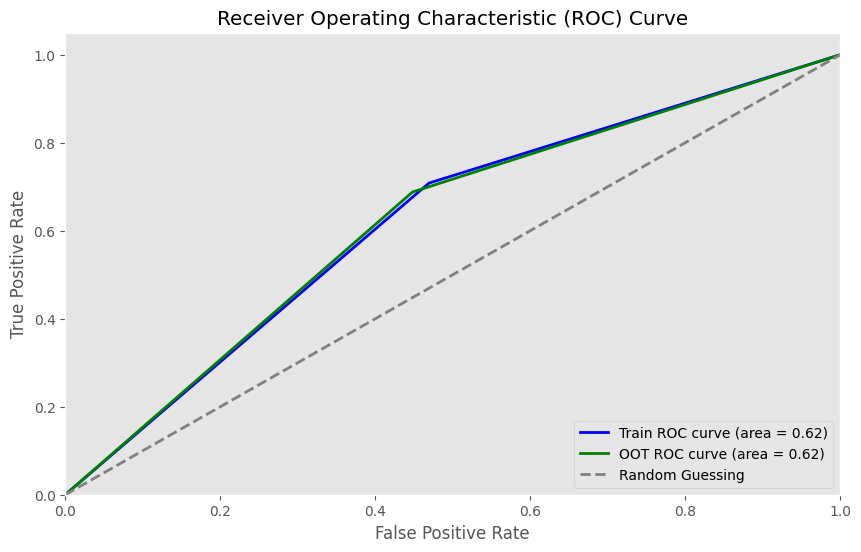

In [3823]:
# ROC Curve for Training Set
fpr_train, tpr_train, _ = roc_curve(df_train_final_y, predictions_train)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC Curve for OOT Set
fpr_oot, tpr_oot, _ = roc_curve(df_oot_final_y, predictions_oot)
roc_auc_oot = auc(fpr_oot, tpr_oot)

# Plotting the ROC Curve
plt.figure(figsize=(10, 6))

# Training Set
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')

# OOT Set
plt.plot(fpr_oot, tpr_oot, color='green', lw=2, label=f'OOT ROC curve (area = {roc_auc_oot:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guessing')

# Axis Labels and Title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🛠️ Pipeline</h1>
    <p style="font-size: 1.2em; text-align: center;">
        Here, we'll refactor part of our code into a scikit-learn Pipeline for improved reusability and streamlined processing.
    </p>
</div>

---

## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

### Treinar um modelo de regressão logistica com o resultado

### Salvar o pickle file do modelo treinado

In [3773]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

NameError: name 'model' is not defined

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

In [ ]:
from pycaret.classification import *
models()

In [ ]:
xxx = create_model('xxx')

### Salvar o arquivo do modelo treinado

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.